In [2]:
%load_ext autoreload
%autoreload 2

from sklearn.covariance import ledoit_wolf
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.utils.extmath import fast_logdet, randomized_svd, svd_flip
from torchvision import models, transforms

from data.mnist_novelty import MNIST_OneClass
from meanshift.data.cifar_novelty import Cifar10_OneClass
from meanshift.data.mvtec import *
from meanshift import *

MVTEC_PATH="../../../../nas-files/mvtec"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = "cuda"
torch.cuda.is_available()

True

# EfficientNet-B4

In [2]:
net = models.efficientnet_b4(pretrained=True).features
net = net.to(device)
net = net.eval()

In [ ]:
log = []

receptive_fields = [4, 8, 16, 16]
strides = [4, 8, 16, 16]

for j, layers in enumerate([[2], [4], [5], [6]]):
    
    for run in range(3):

        for clazz in [0, 3, 10, 13]:

            X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=False, MVTEC_PATH=MVTEC_PATH, fold=run )
            
            model = DeepMeanShift(features="eff", blocks=layers, receptive_field=receptive_fields[j])
            model = model.fit(X_, verbose=True, A=80, P=64, s=strides[j])
            
            auc = model.evaluate(X_valid_, X_test_)
            log.append(pd.DataFrame(np.asarray([run, clazz, layers[0], auc])[:, None].T, columns=["run", "class", "layers", "auc_local"])) 

            display(log[-1])
#pd.concat(log).to_csv("./experiments/Eff-Net-layers_L.csv")

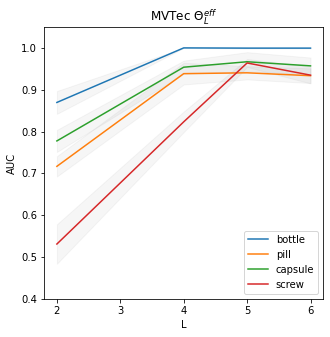

In [3]:
import tikzplotlib
plt.rcParams["figure.figsize"] = (5, 5)

x = [2, 4, 5, 6]
xticks = [2, 3, 4, 5, 6]

colors = ["b", "g", "r", "orange", "pink"]
dat = pd.read_csv("./experiments/Eff-Net-layers_L2.csv")

for cls in [0, 3, 10, 13]:
    log_ = dat[dat["class"] == cls]
    mean = log_.groupby("layers").mean()["auc_local"]
    s = log_.groupby("layers").std()["auc_local"]
    plt.plot(x, mean, label=MVTEC.CLASSES[cls])
    plt.fill_between(x, mean-s, mean+s, color="grey", alpha=.07)

plt.title(r"MVTec $\Theta^{eff}_L$")
plt.xticks(xticks)
plt.ylim(0.4, 1.05)
plt.ylabel("AUC")
plt.xlabel(r"L")
plt.legend()

tikzplotlib.save(f"tex/MVTEC_Block_L.tex")
plt.show()

In [ ]:
log = []
layers = [5, 6]

for cov_est in ["ledoit", "ledoit05", "ledoit025", "ledoit01", "full"]:

    for run in range(3):

        for clazz in [0, 3, 10, 13]:

            X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=False, MVTEC_PATH=MVTEC_PATH, fold=run )

            X = concat_features(X_, net, blocks=layers, fmap_pool=False)
            X_valid = concat_features(X_valid_, net, blocks=layers, fmap_pool=False)
            X_test = concat_features(X_test_, net, blocks=layers, fmap_pool=False)

            for p in [5]:

                for n in [10, 20, 50, 100, 500]:

                    for r in [2]:

                        mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode=cov_est, BSZ=(p, p), rho=r)
                        s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
                        s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

                        auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

                        s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
                        s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

                        auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

                        log.append(pd.DataFrame(np.asarray([run, cov_est, clazz, p, layers[0], n, r, auc, auc_local])[:, None].T, columns=["run", "cov_est", "class", "BSZ", "layers", "n_samples", "rho", "auc", "auc_local"])) 

            display(log[-1])
pd.concat(log).to_csv("./experiments/cov_vs_n_full.csv")

In [36]:
# GLOBAL layer 5/6 "ledoit05"
log__ = pd.concat(log)

for cov_est in ["ledoit05", "ledoit025", "ledoit01", "ledoit", "full"]:
    log_ = log__[log__["cov_est"] == cov_est].drop(columns="cov_est").astype(np.float32)
    for p in [5]:
        print("\n")
        for r in [2]:
            print("\n")
            print(cov_est)
            for clazz in  [0, 3, 10, 13]:
                for n in [10, 20, 50, 100, 500]:
                 
                    auc = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.BSZ == p) & (log_.rho == r) ].groupby("run").mean()["auc"]
                    auc_local = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.BSZ == p) & (log_.rho == r) ].groupby("run").mean()["auc_local"]
                    print(f"class={MVTEC.CLASSES[clazz]:10s}, p={p}, rho={r}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )





ledoit05
class=pill      , p=5, rho=2, n_samples=10 	auc: 0.780 ± 0.027 	auc_local: 0.893 ± 0.025
class=pill      , p=5, rho=2, n_samples=20 	auc: 0.802 ± 0.015 	auc_local: 0.897 ± 0.026
class=pill      , p=5, rho=2, n_samples=50 	auc: 0.842 ± 0.025 	auc_local: 0.920 ± 0.019
class=pill      , p=5, rho=2, n_samples=100 	auc: 0.851 ± 0.027 	auc_local: 0.924 ± 0.019
class=pill      , p=5, rho=2, n_samples=500 	auc: 0.857 ± 0.019 	auc_local: 0.926 ± 0.016
class=capsule   , p=5, rho=2, n_samples=10 	auc: 0.844 ± 0.077 	auc_local: 0.853 ± 0.047
class=capsule   , p=5, rho=2, n_samples=20 	auc: 0.857 ± 0.056 	auc_local: 0.899 ± 0.036
class=capsule   , p=5, rho=2, n_samples=50 	auc: 0.897 ± 0.024 	auc_local: 0.930 ± 0.022
class=capsule   , p=5, rho=2, n_samples=100 	auc: 0.914 ± 0.022 	auc_local: 0.937 ± 0.028
class=capsule   , p=5, rho=2, n_samples=500 	auc: 0.917 ± 0.020 	auc_local: 0.945 ± 0.023
class=screw     , p=5, rho=2, n_samples=10 	auc: 0.546 ± 0.059 	auc_local: 0.548 ± 0.059
clas

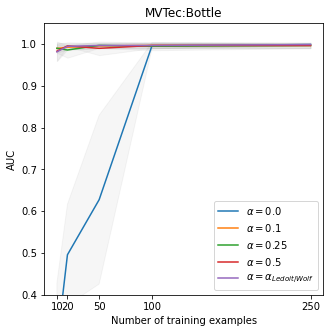

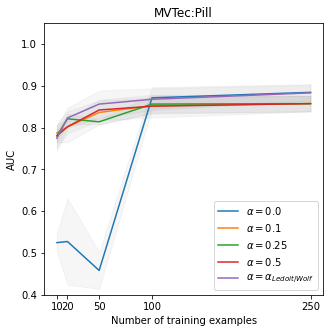

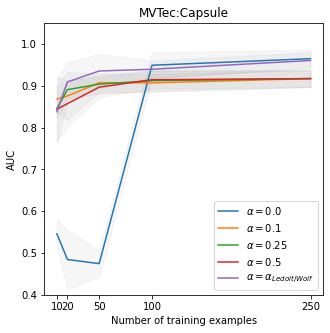

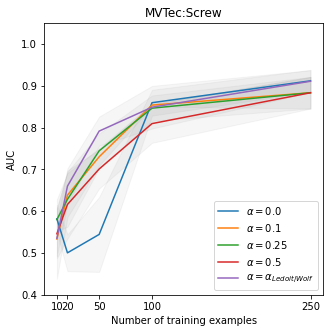

In [118]:
import tikzplotlib
plt.rcParams["figure.figsize"] = (5, 5)

x = [10, 20, 50, 100, 250]
xticks = [10, 20, 50, 100, 250]

names = [r"$\alpha=0.0$", r"$\alpha=0.1$", r"$\alpha=0.25$", r"$\alpha=0.5$", r"$\alpha=\alpha_{Ledoit/Wolf}$"]
colors = ["b", "g", "r", "orange", "pink"]
dat = pd.read_csv("./experiments/cov_vs_n_full.csv")

for cls in [0, 3, 10, 13]:
    for j,cov_est in enumerate(["full", "ledoit01", "ledoit025", "ledoit05", "ledoit"]):
        log_ = dat[dat["class"] == cls]
        log_ = log_[log_["cov_est"] == cov_est]
        mean = log_.groupby("n_samples").mean()["auc"]
        s = log_.groupby("n_samples").std()["auc"]
        plt.plot(x, mean, label=names[j])
        plt.fill_between(x, mean-s, mean+s, color="grey", alpha=.07)

        
    plt.title("MVTec:"+MVTEC.CLASSES[cls].title())
    plt.xticks(xticks)
    plt.ylim(0.4, 1.05)
    plt.ylabel("AUC")
    plt.xlabel("Number of training examples")
    plt.legend()
    
    tikzplotlib.save(f"tex/n_vs_cov_{MVTEC.CLASSES[cls]}.tex")
    plt.show()

In [44]:
log = []
layers = [5, 6]

for run in range(5):

    for clazz in range(0, 15):

        X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=False, MVTEC_PATH=MVTEC_PATH, fold=run )

        X = concat_features(X_, net, blocks=layers, fmap_pool=False)
        X_valid = concat_features(X_valid_, net, blocks=layers, fmap_pool=False)
        X_test = concat_features(X_test_, net, blocks=layers, fmap_pool=False)
        
        for p in [5, 6]:
        
            for n in [500]:
                
                for r in [2, 3]:

                    mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p), rho=r)
                    s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
                    s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

                    auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

                    mu, cov, T = estimate_global_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p))

                    s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
                    s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

                    auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

                    log.append(pd.DataFrame(np.asarray([run, clazz, p, layers[0], n, r, auc, auc_local])[:, None].T, columns=["run", "class", "BSZ", "layers", "n_samples", "rho", "auc", "auc_local"])) 

        display(pd.concat(log))


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,1.0,14.0,4.0,7.0,500.0,3.0,0.948333,0.959583
0,0.0,0.0,5.0,7.0,500.0,2.0,0.997619,0.998413
0,0.0,0.0,5.0,7.0,500.0,3.0,0.997619,0.997619
0,0.0,0.0,6.0,7.0,500.0,2.0,0.998413,0.998413


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,0.0,0.0,6.0,7.0,500.0,3.0,0.998413,0.998413
0,0.0,1.0,5.0,7.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,5.0,7.0,500.0,3.0,1.000000,1.000000
0,0.0,1.0,6.0,7.0,500.0,2.0,0.999599,0.999599


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,0.0,1.0,6.0,7.0,500.0,3.0,0.999599,0.999599
0,0.0,2.0,5.0,7.0,500.0,2.0,1.000000,1.000000
0,0.0,2.0,5.0,7.0,500.0,3.0,1.000000,1.000000
0,0.0,2.0,6.0,7.0,500.0,2.0,1.000000,1.000000


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,0.0,2.0,6.0,7.0,500.0,3.0,1.000000,1.000000
0,0.0,3.0,5.0,7.0,500.0,2.0,0.897436,0.913803
0,0.0,3.0,5.0,7.0,500.0,3.0,0.897436,0.897436
0,0.0,3.0,6.0,7.0,500.0,2.0,0.926350,0.926350


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,0.0,3.0,6.0,7.0,500.0,3.0,0.926350,0.926350
0,0.0,4.0,5.0,7.0,500.0,2.0,0.982684,0.985209
0,0.0,4.0,5.0,7.0,500.0,3.0,0.982684,0.982684
0,0.0,4.0,6.0,7.0,500.0,2.0,0.983766,0.983766


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,0.0,4.0,6.0,7.0,500.0,3.0,0.983766,0.983766
0,0.0,5.0,5.0,7.0,500.0,2.0,1.000000,1.000000
0,0.0,5.0,5.0,7.0,500.0,3.0,1.000000,1.000000
0,0.0,5.0,6.0,7.0,500.0,2.0,1.000000,1.000000


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,0.0,5.0,6.0,7.0,500.0,3.0,1.000000,1.000000
0,0.0,6.0,5.0,7.0,500.0,2.0,0.993628,0.994753
0,0.0,6.0,5.0,7.0,500.0,3.0,0.993628,0.993628
0,0.0,6.0,6.0,7.0,500.0,2.0,0.993816,0.993816


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,0.0,6.0,6.0,7.0,500.0,3.0,0.993816,0.993816
0,0.0,7.0,5.0,7.0,500.0,2.0,0.979950,0.979950
0,0.0,7.0,5.0,7.0,500.0,3.0,0.979950,0.979950
0,0.0,7.0,6.0,7.0,500.0,2.0,0.979950,0.979950


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,0.0,7.0,6.0,7.0,500.0,3.0,0.979950,0.979950
0,0.0,8.0,5.0,7.0,500.0,2.0,0.980556,0.983333
0,0.0,8.0,5.0,7.0,500.0,3.0,0.980556,0.980556
0,0.0,8.0,6.0,7.0,500.0,2.0,0.986111,0.986111


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,0.0,8.0,6.0,7.0,500.0,3.0,0.986111,0.986111
0,0.0,9.0,5.0,7.0,500.0,2.0,0.980042,0.971376
0,0.0,9.0,5.0,7.0,500.0,3.0,0.980042,0.980042
0,0.0,9.0,6.0,7.0,500.0,2.0,0.974790,0.974790


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,0.0,9.0,6.0,7.0,500.0,3.0,0.974790,0.974790
0,0.0,10.0,5.0,7.0,500.0,2.0,0.982449,0.979657
0,0.0,10.0,5.0,7.0,500.0,3.0,0.982449,0.982449
0,0.0,10.0,6.0,7.0,500.0,2.0,0.980854,0.980854


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,0.0,10.0,6.0,7.0,500.0,3.0,0.980854,0.980854
0,0.0,11.0,5.0,7.0,500.0,2.0,0.990357,0.993929
0,0.0,11.0,5.0,7.0,500.0,3.0,0.990357,0.990357
0,0.0,11.0,6.0,7.0,500.0,2.0,0.992500,0.992500


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,0.0,11.0,6.0,7.0,500.0,3.0,0.992500,0.992500
0,0.0,12.0,5.0,7.0,500.0,2.0,0.973118,0.983382
0,0.0,12.0,5.0,7.0,500.0,3.0,0.973118,0.973118
0,0.0,12.0,6.0,7.0,500.0,2.0,0.971652,0.971652


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,0.0,12.0,6.0,7.0,500.0,3.0,0.971652,0.971652
0,0.0,13.0,5.0,7.0,500.0,2.0,0.958803,0.964747
0,0.0,13.0,5.0,7.0,500.0,3.0,0.958803,0.958803
0,0.0,13.0,6.0,7.0,500.0,2.0,0.963722,0.963722


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,0.0,13.0,6.0,7.0,500.0,3.0,0.963722,0.963722
0,0.0,14.0,5.0,7.0,500.0,2.0,0.972500,0.977500
0,0.0,14.0,5.0,7.0,500.0,3.0,0.972500,0.972500
0,0.0,14.0,6.0,7.0,500.0,2.0,0.976667,0.976667


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,0.0,14.0,6.0,7.0,500.0,3.0,0.976667,0.976667
0,1.0,0.0,5.0,7.0,500.0,2.0,1.000000,1.000000
0,1.0,0.0,5.0,7.0,500.0,3.0,1.000000,1.000000
0,1.0,0.0,6.0,7.0,500.0,2.0,1.000000,1.000000


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,1.0,0.0,6.0,7.0,500.0,3.0,1.000000,1.000000
0,1.0,1.0,5.0,7.0,500.0,2.0,1.000000,1.000000
0,1.0,1.0,5.0,7.0,500.0,3.0,1.000000,1.000000
0,1.0,1.0,6.0,7.0,500.0,2.0,1.000000,1.000000


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,1.0,1.0,6.0,7.0,500.0,3.0,1.000000,1.000000
0,1.0,2.0,5.0,7.0,500.0,2.0,1.000000,1.000000
0,1.0,2.0,5.0,7.0,500.0,3.0,1.000000,1.000000
0,1.0,2.0,6.0,7.0,500.0,2.0,1.000000,1.000000


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,1.0,2.0,6.0,7.0,500.0,3.0,1.000000,1.000000
0,1.0,3.0,5.0,7.0,500.0,2.0,0.913257,0.926350
0,1.0,3.0,5.0,7.0,500.0,3.0,0.913257,0.913257
0,1.0,3.0,6.0,7.0,500.0,2.0,0.933170,0.933170


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,1.0,3.0,6.0,7.0,500.0,3.0,0.933170,0.933170
0,1.0,4.0,5.0,7.0,500.0,2.0,0.983045,0.984848
0,1.0,4.0,5.0,7.0,500.0,3.0,0.983045,0.983045
0,1.0,4.0,6.0,7.0,500.0,2.0,0.983405,0.983405


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,1.0,4.0,6.0,7.0,500.0,3.0,0.983405,0.983405
0,1.0,5.0,5.0,7.0,500.0,2.0,0.992982,0.993860
0,1.0,5.0,5.0,7.0,500.0,3.0,0.992982,0.992982
0,1.0,5.0,6.0,7.0,500.0,2.0,0.993860,0.993860


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,1.0,5.0,6.0,7.0,500.0,3.0,0.993860,0.993860
0,1.0,6.0,5.0,7.0,500.0,2.0,0.986132,0.992504
0,1.0,6.0,5.0,7.0,500.0,3.0,0.986132,0.986132
0,1.0,6.0,6.0,7.0,500.0,2.0,0.989880,0.989880


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,1.0,6.0,6.0,7.0,500.0,3.0,0.989880,0.989880
0,1.0,7.0,5.0,7.0,500.0,2.0,0.974102,0.973266
0,1.0,7.0,5.0,7.0,500.0,3.0,0.974102,0.974102
0,1.0,7.0,6.0,7.0,500.0,2.0,0.973266,0.973266


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,1.0,7.0,6.0,7.0,500.0,3.0,0.973266,0.973266
0,1.0,8.0,5.0,7.0,500.0,2.0,0.988889,0.991667
0,1.0,8.0,5.0,7.0,500.0,3.0,0.988889,0.988889
0,1.0,8.0,6.0,7.0,500.0,2.0,0.991667,0.991667


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,1.0,8.0,6.0,7.0,500.0,3.0,0.991667,0.991667
0,1.0,9.0,5.0,7.0,500.0,2.0,0.986870,0.986082
0,1.0,9.0,5.0,7.0,500.0,3.0,0.986870,0.986870
0,1.0,9.0,6.0,7.0,500.0,2.0,0.986870,0.986870


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,1.0,9.0,6.0,7.0,500.0,3.0,0.986870,0.986870
0,1.0,10.0,5.0,7.0,500.0,2.0,0.985241,0.988432
0,1.0,10.0,5.0,7.0,500.0,3.0,0.985241,0.985241
0,1.0,10.0,6.0,7.0,500.0,2.0,0.985640,0.985640


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,1.0,10.0,6.0,7.0,500.0,3.0,0.985640,0.985640
0,1.0,11.0,5.0,7.0,500.0,2.0,0.995000,0.995357
0,1.0,11.0,5.0,7.0,500.0,3.0,0.995000,0.995000
0,1.0,11.0,6.0,7.0,500.0,2.0,0.994643,0.994643


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,1.0,11.0,6.0,7.0,500.0,3.0,0.994643,0.994643
0,1.0,12.0,5.0,7.0,500.0,2.0,0.991202,0.988759
0,1.0,12.0,5.0,7.0,500.0,3.0,0.991202,0.991202
0,1.0,12.0,6.0,7.0,500.0,2.0,0.985337,0.985337


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,1.0,12.0,6.0,7.0,500.0,3.0,0.985337,0.985337
0,1.0,13.0,5.0,7.0,500.0,2.0,0.984218,0.987702
0,1.0,13.0,5.0,7.0,500.0,3.0,0.984218,0.984218
0,1.0,13.0,6.0,7.0,500.0,2.0,0.986063,0.986063


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,7.0,500.0,2.0,0.993651,0.997619
0,0.0,0.0,1.0,7.0,500.0,3.0,0.993651,0.996032
0,0.0,0.0,2.0,7.0,500.0,2.0,0.993651,0.998413
0,0.0,0.0,2.0,7.0,500.0,3.0,0.993651,0.997619
0,0.0,1.0,1.0,7.0,500.0,2.0,0.993178,1.000000
...,...,...,...,...,...,...,...,...
0,1.0,13.0,6.0,7.0,500.0,3.0,0.986063,0.986063
0,1.0,14.0,5.0,7.0,500.0,2.0,0.953750,0.961250
0,1.0,14.0,5.0,7.0,500.0,3.0,0.953750,0.953750
0,1.0,14.0,6.0,7.0,500.0,2.0,0.958333,0.958333


In [9]:
# GLOBAL layer 5/6
log_ = pd.concat(log)

for p in [4]:
    print("\n")
    for r in [2]:
        for n in [500]:
            auc = log_[ (log_.rho == r) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc"]
            auc_local = log_[ (log_.rho == r) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc_local"]
            print(f"r={r}, p={p}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



r=2, p=4, n_samples=500 	auc: 0.954 ± 0.005 	auc_local: 0.987 ± 0.002


In [49]:
# GLOBAL layer 7
log_ = pd.concat(log)

for p in [1, 2, 3, 4, 5, 6]:
    print("\n")
    for r in [2,3]:
        print("\n")
        for clazz in range(15):
            for n in [500]:
                auc = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.BSZ == p) & (log_.rho == r) ].groupby("run").mean()["auc"]
                auc_local = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.BSZ == p) & (log_.rho == r) ].groupby("run").mean()["auc_local"]
                print(f"class={MVTEC.CLASSES[clazz]:10s}, p={p}, rho={r}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )





class=bottle    , p=1, rho=2, n_samples=500 	auc: 0.998 ± 0.004 	auc_local: 0.999 ± 0.001
class=carpet    , p=1, rho=2, n_samples=500 	auc: 0.996 ± 0.003 	auc_local: 1.000 ± 0.000
class=leather   , p=1, rho=2, n_samples=500 	auc: 1.000 ± 0.000 	auc_local: 1.000 ± 0.000
class=pill      , p=1, rho=2, n_samples=500 	auc: 0.839 ± 0.029 	auc_local: 0.898 ± 0.024
class=tile      , p=1, rho=2, n_samples=500 	auc: 0.980 ± 0.004 	auc_local: 0.985 ± 0.002
class=wood      , p=1, rho=2, n_samples=500 	auc: 0.998 ± 0.003 	auc_local: 0.995 ± 0.003
class=cable     , p=1, rho=2, n_samples=500 	auc: 0.931 ± 0.011 	auc_local: 0.976 ± 0.003
class=grid      , p=1, rho=2, n_samples=500 	auc: 0.953 ± 0.004 	auc_local: 0.979 ± 0.003
class=toothbrush, p=1, rho=2, n_samples=500 	auc: 0.982 ± 0.006 	auc_local: 0.994 ± 0.002
class=zipper    , p=1, rho=2, n_samples=500 	auc: 0.947 ± 0.024 	auc_local: 0.958 ± 0.021
class=capsule   , p=1, rho=2, n_samples=500 	auc: 0.918 ± 0.010 	auc_local: 0.934 ± 0.010
class=

In [50]:
# GLOBAL layer 7
log_ = pd.concat(log)

for p in [1, 2, 3, 4, 5, 6]:
    print("\n")
    for r in [2,3]:
        for n in [500]:
            auc = log_[ (log_.rho == r) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc"]
            auc_local = log_[ (log_.rho == r) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc_local"]
            print(f"r={r}, p={p}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



r=2, p=1, n_samples=500 	auc: 0.950 ± 0.008 	auc_local: 0.966 ± 0.002
r=3, p=1, n_samples=500 	auc: 0.950 ± 0.008 	auc_local: 0.960 ± 0.004


r=2, p=2, n_samples=500 	auc: 0.969 ± 0.005 	auc_local: 0.979 ± 0.003
r=3, p=2, n_samples=500 	auc: 0.969 ± 0.005 	auc_local: 0.976 ± 0.004


r=2, p=3, n_samples=500 	auc: 0.977 ± 0.003 	auc_local: 0.982 ± 0.003
r=3, p=3, n_samples=500 	auc: 0.977 ± 0.003 	auc_local: 0.980 ± 0.003


r=2, p=4, n_samples=500 	auc: 0.980 ± 0.003 	auc_local: 0.983 ± 0.002
r=3, p=4, n_samples=500 	auc: 0.980 ± 0.003 	auc_local: 0.982 ± 0.002


r=2, p=5, n_samples=500 	auc: 0.981 ± 0.002 	auc_local: 0.984 ± 0.002
r=3, p=5, n_samples=500 	auc: 0.981 ± 0.002 	auc_local: 0.981 ± 0.002


r=2, p=6, n_samples=500 	auc: 0.983 ± 0.001 	auc_local: 0.983 ± 0.001
r=3, p=6, n_samples=500 	auc: 0.983 ± 0.001 	auc_local: 0.983 ± 0.001


In [27]:
# GLOBAL layer 5/6
log_ = pd.concat(log)

for p in [1]:
    print("\n")
    for r in [2,3,4]:
        for n in [500]:
            auc = log_[ (log_.rho == r) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc"]
            auc_local = log_[ (log_.rho == r) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc_local"]
            print(f"r={r}, p={p}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



r=2, p=1, n_samples=500 	auc: 0.856 ± 0.009 	auc_local: 0.963 ± 0.003
r=3, p=1, n_samples=500 	auc: 0.856 ± 0.009 	auc_local: 0.962 ± 0.002
r=4, p=1, n_samples=500 	auc: 0.856 ± 0.009 	auc_local: 0.953 ± 0.002


In [33]:
# GLOBAL layer 5/6
log_ = pd.concat(log)

for p in [1]:
    print("\n")
    for r in [2,3,4]:
        print("\n")
        for clazz in range(15):
            for n in [500]:
                auc = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.BSZ == p) & (log_.rho == r) ].groupby("run").mean()["auc"]
                auc_local = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.BSZ == p) & (log_.rho == r) ].groupby("run").mean()["auc_local"]
                print(f"class={MVTEC.CLASSES[clazz]:10s}, p={p}, rho={r}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )





class=bottle    , p=1, rho=2, n_samples=500 	auc: 0.989 ± 0.012 	auc_local: 0.995 ± 0.004
class=carpet    , p=1, rho=2, n_samples=500 	auc: 0.982 ± 0.012 	auc_local: 1.000 ± 0.001
class=leather   , p=1, rho=2, n_samples=500 	auc: 1.000 ± 0.000 	auc_local: 1.000 ± 0.000
class=pill      , p=1, rho=2, n_samples=500 	auc: 0.716 ± 0.037 	auc_local: 0.935 ± 0.036
class=tile      , p=1, rho=2, n_samples=500 	auc: 0.948 ± 0.005 	auc_local: 0.985 ± 0.004
class=wood      , p=1, rho=2, n_samples=500 	auc: 0.995 ± 0.005 	auc_local: 0.993 ± 0.004
class=cable     , p=1, rho=2, n_samples=500 	auc: 0.817 ± 0.032 	auc_local: 0.933 ± 0.002
class=grid      , p=1, rho=2, n_samples=500 	auc: 0.729 ± 0.015 	auc_local: 0.920 ± 0.022
class=toothbrush, p=1, rho=2, n_samples=500 	auc: 0.893 ± 0.045 	auc_local: 0.999 ± 0.002
class=zipper    , p=1, rho=2, n_samples=500 	auc: 0.869 ± 0.052 	auc_local: 0.980 ± 0.009
class=capsule   , p=1, rho=2, n_samples=500 	auc: 0.820 ± 0.041 	auc_local: 0.938 ± 0.014
class=

In [11]:
# GLOBAL layer 5/6
log_ = pd.concat(log)

for p in [4]:
    print("\n")
    for clazz in range(15):
        for n in [500]:
            auc = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc"]
            auc_local = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc_local"]
            print(f"class={MVTEC.CLASSES[clazz]:10s}, p={p}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



class=bottle    , p=4, n_samples=500 	auc: 0.998 ± 0.004 	auc_local: 0.999 ± 0.001
class=carpet    , p=4, n_samples=500 	auc: 0.996 ± 0.002 	auc_local: 1.000 ± 0.000
class=leather   , p=4, n_samples=500 	auc: 1.000 ± 0.000 	auc_local: 1.000 ± 0.000
class=pill      , p=4, n_samples=500 	auc: 0.864 ± 0.020 	auc_local: 0.939 ± 0.017
class=tile      , p=4, n_samples=500 	auc: 0.977 ± 0.003 	auc_local: 0.987 ± 0.001
class=wood      , p=4, n_samples=500 	auc: 0.998 ± 0.004 	auc_local: 0.994 ± 0.004
class=cable     , p=4, n_samples=500 	auc: 0.965 ± 0.012 	auc_local: 0.993 ± 0.000
class=grid      , p=4, n_samples=500 	auc: 0.926 ± 0.013 	auc_local: 0.994 ± 0.004
class=toothbrush, p=4, n_samples=500 	auc: 0.958 ± 0.015 	auc_local: 0.999 ± 0.002
class=zipper    , p=4, n_samples=500 	auc: 0.980 ± 0.011 	auc_local: 0.996 ± 0.004
class=capsule   , p=4, n_samples=500 	auc: 0.953 ± 0.018 	auc_local: 0.965 ± 0.023
class=hazelnut  , p=4, n_samples=500 	auc: 0.977 ± 0.016 	auc_local: 1.000 ± 0.000
cl

In [6]:
# GLOBAL layer 5/6
log_ = pd.concat(log)

for p in [2]:
    print("\n")
    for r in [2, 3, 4]:
        for n in [500]:
            auc = log_[ (log_.rho == r) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc"]
            auc_local = log_[ (log_.rho == r) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc_local"]
            print(f"r={r}, p={p}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



r=2, p=2, n_samples=500 	auc: 0.866 ± nan 	auc_local: 0.971 ± nan
r=3, p=2, n_samples=500 	auc: 0.866 ± nan 	auc_local: 0.970 ± nan
r=4, p=2, n_samples=500 	auc: 0.866 ± nan 	auc_local: 0.963 ± nan


In [7]:
# GLOBAL layer 5/6
log_ = pd.concat(log)

for p in [3, 4, 5, 6]:
    print("\n")
    for r in [6, 4, 2]:
        for n in [500]:
            auc = log_[ (log_.rho == r) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc"]
            auc_local = log_[ (log_.rho == r) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc_local"]
            print(f"r={r}, p={p}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



r=6, p=3, n_samples=500 	auc: nan ± nan 	auc_local: nan ± nan
r=4, p=3, n_samples=500 	auc: 0.902 ± nan 	auc_local: 0.974 ± nan
r=2, p=3, n_samples=500 	auc: 0.902 ± nan 	auc_local: 0.979 ± nan


r=6, p=4, n_samples=500 	auc: nan ± nan 	auc_local: nan ± nan
r=4, p=4, n_samples=500 	auc: 0.924 ± nan 	auc_local: 0.977 ± nan
r=2, p=4, n_samples=500 	auc: 0.924 ± nan 	auc_local: 0.982 ± nan


r=6, p=5, n_samples=500 	auc: nan ± nan 	auc_local: nan ± nan
r=4, p=5, n_samples=500 	auc: 0.938 ± nan 	auc_local: 0.977 ± nan
r=2, p=5, n_samples=500 	auc: 0.938 ± nan 	auc_local: 0.983 ± nan


r=6, p=6, n_samples=500 	auc: nan ± nan 	auc_local: nan ± nan
r=4, p=6, n_samples=500 	auc: 0.946 ± nan 	auc_local: 0.977 ± nan
r=2, p=6, n_samples=500 	auc: 0.946 ± nan 	auc_local: 0.983 ± nan


In [127]:
# GLOBAL layer 5/6
log_ = pd.concat(log)

for p in [3, 4, 5, 6]:
    print("\n")
    for clazz in range(15):
        for n in [500]:
            auc = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc"]
            auc_local = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc_local"]
            print(f"class={MVTEC.CLASSES[clazz]:10s}, p={p}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



class=bottle    , p=3, n_samples=500 	auc: 0.998 ± 0.000 	auc_local: 1.000 ± 0.000
class=carpet    , p=3, n_samples=500 	auc: 0.754 ± 0.000 	auc_local: 1.000 ± 0.000
class=leather   , p=3, n_samples=500 	auc: 0.989 ± 0.000 	auc_local: 1.000 ± 0.000
class=pill      , p=3, n_samples=500 	auc: 0.838 ± 0.000 	auc_local: 0.948 ± 0.000
class=tile      , p=3, n_samples=500 	auc: 0.974 ± 0.000 	auc_local: 0.987 ± 0.000
class=wood      , p=3, n_samples=500 	auc: 0.972 ± 0.000 	auc_local: 0.987 ± 0.000
class=cable     , p=3, n_samples=500 	auc: 0.930 ± 0.000 	auc_local: 0.988 ± 0.000
class=grid      , p=3, n_samples=500 	auc: 0.694 ± 0.000 	auc_local: 0.946 ± 0.000
class=toothbrush, p=3, n_samples=500 	auc: 0.939 ± 0.000 	auc_local: 1.000 ± 0.000
class=zipper    , p=3, n_samples=500 	auc: 0.966 ± 0.000 	auc_local: 0.984 ± 0.000
class=capsule   , p=3, n_samples=500 	auc: 0.901 ± 0.000 	auc_local: 0.935 ± 0.000
class=hazelnut  , p=3, n_samples=500 	auc: 0.984 ± 0.000 	auc_local: 1.000 ± 0.000
cl

## Test Label efficiency

In [105]:
# GLOBAL layer 5/6
log_ = pd.concat(log)

for p in [3, 4, 5, 6]:
    print("\n")
    for n in [1, 5, 10, 25, 50, 80, 100]:
        auc = log_[ (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc"]
        auc_local = log_[ (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc_local"]
        print(f"p={p}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



p=3, n_samples=1 	auc: 0.712 ± 0.075 	auc_local: 0.859 ± 0.093
p=3, n_samples=5 	auc: 0.797 ± 0.038 	auc_local: 0.928 ± 0.048
p=3, n_samples=10 	auc: 0.833 ± 0.033 	auc_local: 0.948 ± 0.033
p=3, n_samples=25 	auc: 0.867 ± 0.031 	auc_local: 0.966 ± 0.023
p=3, n_samples=50 	auc: 0.886 ± 0.017 	auc_local: 0.978 ± 0.015
p=3, n_samples=80 	auc: 0.891 ± 0.014 	auc_local: 0.978 ± 0.016
p=3, n_samples=100 	auc: 0.893 ± 0.011 	auc_local: 0.981 ± 0.013


p=4, n_samples=1 	auc: 0.702 ± 0.037 	auc_local: 0.860 ± 0.088
p=4, n_samples=5 	auc: 0.796 ± 0.053 	auc_local: 0.923 ± 0.050
p=4, n_samples=10 	auc: 0.831 ± 0.037 	auc_local: 0.939 ± 0.040
p=4, n_samples=25 	auc: 0.875 ± 0.029 	auc_local: 0.964 ± 0.023
p=4, n_samples=50 	auc: 0.896 ± 0.020 	auc_local: 0.971 ± 0.019
p=4, n_samples=80 	auc: 0.908 ± 0.016 	auc_local: 0.979 ± 0.014
p=4, n_samples=100 	auc: 0.918 ± 0.010 	auc_local: 0.979 ± 0.014


p=5, n_samples=1 	auc: 0.738 ± 0.083 	auc_local: 0.854 ± 0.095
p=5, n_samples=5 	auc: 0.793 ± 0.061 

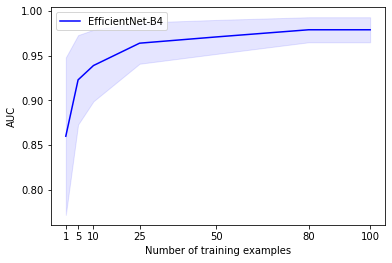

In [8]:
import tikzplotlib

X_mean = [0.860 , 0.923 , 0.939 , 0.964 , 0.971 , 0.979 , 0.979]
X_std = [0.088, 0.050, 0.040, 0.023, 0.019, 0.014, 0.014]
y = [1, 5, 10, 25, 50, 80, 100]

plt.plot(y, np.asarray(X_mean), label="EfficientNet-B4", color="b")
plt.fill_between(y, np.asarray(X_mean)-np.asarray(X_std), np.asarray(X_mean)+np.asarray(X_std), color='b', alpha=.1)
plt.xticks(y)
plt.ylabel("AUC")
plt.xlabel("Number of training examples")
plt.title("")
plt.legend()
tikzplotlib.save("eff_dataefficiency.tex")

# Raw Pixels

In [ ]:
A = 80
P = 64
s = 16
p = 1
blocks = [5]
r = int( (A - P)/s + 1 )

#log = []

netname = "raw"

for run in range(0,3):
    for clazz in range(0, 15):

        X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=True, MVTEC_PATH=MVTEC_PATH, fold=run )
        
        net, layer_map = get_pca(X_, 1.0, P, s)

        X = patches_to_feature_space(X_, net, P=P, s=s, blocks=blocks, layer_map=layer_map)
        X_valid = patches_to_feature_space(X_valid_, net, P=P, s=s, blocks=blocks, layer_map=layer_map)
        X_test = patches_to_feature_space(X_test_, net, P=P, s=s, blocks=blocks, layer_map=layer_map)

        print(X.shape)

        mu, means, cov, T = estimate_statistics(X, mode="ledoit", BSZ=(p, p), rho=r)
        s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
        s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

        auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

        s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
        s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

        auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

        log.append(pd.DataFrame(np.asarray([run, netname, clazz, MVTEC.CLASSES[clazz], A, P, s, p, blocks[0], len(X), r, auc, auc_local])[:, None].T, columns=["run", "fmap", "class", "class_name", "A", "P", "s", "BSZ", "layers", "n_samples", "rho", "auc", "auc_local"])) 

        display(log[-1])


(60, 7260, 11, 11)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,1,raw,8,toothbrush,80,64,16,1,5,60,2,0.7666666666666667,0.6527777777777778


(240, 12288, 11, 11)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,1,raw,9,zipper,80,64,16,1,5,240,2,0.751313025210084,0.9535189075630252


(219, 12288, 11, 11)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,1,raw,10,capsule,80,64,16,1,5,219,2,0.6693258875149581,0.6956521739130436


(391, 12288, 11, 11)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,1,raw,11,hazelnut,80,64,16,1,5,391,2,0.8403571428571429,0.8239285714285715


(220, 12288, 11, 11)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,1,raw,12,metal_nut,80,64,16,1,5,220,2,0.20869990224828933,0.2653958944281525


(320, 12288, 11, 11)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,1,raw,13,screw,80,64,16,1,5,320,2,0.5583111293297807,0.6195941791350686


(213, 12288, 11, 11)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,1,raw,14,transistor,80,64,16,1,5,213,2,0.43749999999999994,0.3845833333333334


(209, 12288, 11, 11)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,2,raw,0,bottle,80,64,16,1,5,209,2,0.8634920634920635,0.9055555555555556


(280, 12288, 11, 11)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,2,raw,1,carpet,80,64,16,1,5,280,2,0.7885232744783307,0.8065810593900482


In [29]:
n=-1 # p100

log_ = pd.concat(log).drop(columns=["class_name", "fmap"]).astype(np.float32)

for A in [80]:
    print("\n")
    auc = log_[  (log_.A == A) ].groupby("run").mean()["auc"]
    auc_local = log_[   (log_.A == A) ].groupby("run").mean()["auc_local"]
    print(f"A={A}, P={P}. n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )
            
for A in [80]:
    print("\n")
    for clazz in range(15):
        auc = log_[(log_["class"] == clazz)  & (log_.A == A) ].groupby("run").mean()["auc"]
        auc_local = log_[(log_["class"] == clazz)  & (log_.A == A) ].groupby("run").mean()["auc_local"]
        print(f"class={MVTEC.CLASSES[clazz]:10s}, A={A}, P={P}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



A=80, P=64. n_samples=-1 	auc: 0.705 ± 0.019 	auc_local: 0.771 ± 0.051


class=bottle    , A=80, P=64, n_samples=-1 	auc: 0.843 ± 0.060 	auc_local: 0.865 ± 0.056
class=carpet    , A=80, P=64, n_samples=-1 	auc: 0.800 ± 0.026 	auc_local: 0.816 ± 0.013
class=leather   , A=80, P=64, n_samples=-1 	auc: 0.998 ± 0.002 	auc_local: 0.989 ± 0.004
class=pill      , A=80, P=64, n_samples=-1 	auc: 0.756 ± 0.010 	auc_local: 0.848 ± 0.026
class=tile      , A=80, P=64, n_samples=-1 	auc: 0.791 ± 0.027 	auc_local: 0.891 ± 0.012
class=wood      , A=80, P=64, n_samples=-1 	auc: 0.821 ± 0.041 	auc_local: 0.907 ± 0.010
class=cable     , A=80, P=64, n_samples=-1 	auc: 0.403 ± 0.025 	auc_local: 0.361 ± 0.015
class=grid      , A=80, P=64, n_samples=-1 	auc: 0.562 ± 0.045 	auc_local: 0.924 ± 0.032
class=toothbrush, A=80, P=64, n_samples=-1 	auc: 0.751 ± 0.022 	auc_local: 0.667 ± 0.020
class=zipper    , A=80, P=64, n_samples=-1 	auc: 0.778 ± 0.038 	auc_local: 0.952 ± 0.002
class=capsule   , A=80, P=64, n_sam

In [7]:
n=-1 # p99

log_ = pd.concat(log).drop(columns=["class_name", "fmap"]).astype(np.float32)

for A in [80]:
    print("\n")
    auc = log_[  (log_.A == A) ].groupby("run").mean()["auc"]
    auc_local = log_[   (log_.A == A) ].groupby("run").mean()["auc_local"]
    print(f"A={A}, P={P}. n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )
            
for A in [80]:
    print("\n")
    for clazz in range(15):
        auc = log_[(log_["class"] == clazz)  & (log_.A == A) ].groupby("run").mean()["auc"]
        auc_local = log_[(log_["class"] == clazz)  & (log_.A == A) ].groupby("run").mean()["auc_local"]
        print(f"class={MVTEC.CLASSES[clazz]:10s}, A={A}, P={P}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



A=80, P=64. n_samples=-1 	auc: 0.673 ± 0.008 	auc_local: 0.741 ± 0.035


class=bottle    , A=80, P=64, n_samples=-1 	auc: 0.813 ± 0.067 	auc_local: 0.886 ± 0.019
class=carpet    , A=80, P=64, n_samples=-1 	auc: 0.832 ± 0.023 	auc_local: 0.744 ± 0.015
class=leather   , A=80, P=64, n_samples=-1 	auc: 0.999 ± 0.000 	auc_local: 0.996 ± 0.001
class=pill      , A=80, P=64, n_samples=-1 	auc: 0.619 ± 0.090 	auc_local: 0.688 ± 0.037
class=tile      , A=80, P=64, n_samples=-1 	auc: 0.594 ± 0.047 	auc_local: 0.649 ± 0.018
class=wood      , A=80, P=64, n_samples=-1 	auc: 0.854 ± 0.030 	auc_local: 0.936 ± 0.023
class=cable     , A=80, P=64, n_samples=-1 	auc: 0.480 ± 0.033 	auc_local: 0.410 ± 0.025
class=grid      , A=80, P=64, n_samples=-1 	auc: 0.594 ± 0.063 	auc_local: 0.944 ± 0.031
class=toothbrush, A=80, P=64, n_samples=-1 	auc: 0.690 ± 0.065 	auc_local: 0.899 ± 0.023
class=zipper    , A=80, P=64, n_samples=-1 	auc: 0.600 ± 0.054 	auc_local: 0.848 ± 0.029
class=capsule   , A=80, P=64, n_sam

In [5]:
n=-1 # p90

log_ = pd.concat(log).drop(columns=["class_name", "fmap"]).astype(np.float32)

for A in [80]:
    print("\n")
    auc = log_[  (log_.A == A) ].groupby("run").mean()["auc"]
    auc_local = log_[   (log_.A == A) ].groupby("run").mean()["auc_local"]
    print(f"A={A}, P={P}. n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )
            
for A in [80]:
    print("\n")
    for clazz in range(15):
        auc = log_[(log_["class"] == clazz)  & (log_.A == A) ].groupby("run").mean()["auc"]
        auc_local = log_[(log_["class"] == clazz)  & (log_.A == A) ].groupby("run").mean()["auc_local"]
        print(f"class={MVTEC.CLASSES[clazz]:10s}, A={A}, P={P}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



A=80, P=64. n_samples=-1 	auc: 0.607 ± 0.004 	auc_local: 0.648 ± 0.013


class=bottle    , A=80, P=64, n_samples=-1 	auc: 0.692 ± 0.072 	auc_local: 0.953 ± 0.008
class=carpet    , A=80, P=64, n_samples=-1 	auc: 0.849 ± 0.019 	auc_local: 0.735 ± 0.023
class=leather   , A=80, P=64, n_samples=-1 	auc: 0.999 ± 0.001 	auc_local: 0.999 ± 0.000
class=pill      , A=80, P=64, n_samples=-1 	auc: 0.487 ± 0.059 	auc_local: 0.698 ± 0.031
class=tile      , A=80, P=64, n_samples=-1 	auc: 0.584 ± 0.041 	auc_local: 0.648 ± 0.044
class=wood      , A=80, P=64, n_samples=-1 	auc: 0.736 ± 0.034 	auc_local: 0.754 ± 0.093
class=cable     , A=80, P=64, n_samples=-1 	auc: 0.613 ± 0.024 	auc_local: 0.525 ± 0.016
class=grid      , A=80, P=64, n_samples=-1 	auc: 0.390 ± 0.063 	auc_local: 0.468 ± 0.095
class=toothbrush, A=80, P=64, n_samples=-1 	auc: 0.608 ± 0.106 	auc_local: 0.712 ± 0.075
class=zipper    , A=80, P=64, n_samples=-1 	auc: 0.504 ± 0.045 	auc_local: 0.571 ± 0.046
class=capsule   , A=80, P=64, n_sam

# Vision Image Transformer

In [3]:
net, layer_map = get_fmap("vitb16")
net = net.to(device)
next(net.parameters()).device

device(type='cuda', index=0)

In [5]:
A = 112
P = 112
s = 112
p = 1
blocks = [7]

r = int( (A - P)/s + 1 )

log = []

netname = "vit16"

for run in range(1):
    for clazz in range(0, 15):

        X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=True, MVTEC_PATH=MVTEC_PATH, fold=run )

        X = patches_to_feature_space_vit(X_, net, P=P, s=s, blocks=blocks, layer_map=layer_map)
        X_valid = patches_to_feature_space_vit(X_valid_, net, P=P, s=s, blocks=blocks, layer_map=layer_map)
        X_test = patches_to_feature_space_vit(X_test_, net, P=P, s=s, blocks=blocks, layer_map=layer_map)

        print(X.shape)

        mu, means, cov, T = estimate_statistics(X, mode="ledoit", BSZ=(p, p), rho=r)
        s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
        s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

        auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

        mu, cov, T = estimate_global_statistics(X, mode="ledoit", BSZ=(p, p))

        s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
        s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

        auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

        log.append(pd.DataFrame(np.asarray([run, netname, clazz, MVTEC.CLASSES[clazz], A, P, s, p, blocks[0], len(X), r, auc, auc_local])[:, None].T, columns=["run", "fmap", "class", "class_name", "A", "P", "s", "BSZ", "layers", "n_samples", "rho", "auc", "auc_local"])) 

        display(log[-1])


(209, 768, 8, 8)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,0,bottle,112,112,16,1,7,209,1,0.9952380952380953,0.9992063492063492


(280, 768, 8, 8)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,1,carpet,112,112,16,1,7,280,1,1.0,1.0


(245, 768, 8, 8)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,2,leather,112,112,16,1,7,245,1,1.0,1.0


(267, 768, 8, 8)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,3,pill,112,112,16,1,7,267,1,0.9012547735951991,0.9271685761047463


(230, 768, 8, 8)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,4,tile,112,112,16,1,7,230,1,0.9743867243867244,0.9855699855699855


(247, 768, 8, 8)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,5,wood,112,112,16,1,7,247,1,1.0,0.9947368421052633


(224, 768, 8, 8)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,6,cable,112,112,16,1,7,224,1,0.9550224887556222,0.848575712143928


(264, 768, 8, 8)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,7,grid,112,112,16,1,7,264,1,0.7936507936507937,0.9014202172096909


(60, 768, 8, 8)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,8,toothbrush,112,112,16,1,7,60,1,0.9694444444444446,0.9833333333333334


(240, 768, 8, 8)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,9,zipper,112,112,16,1,7,240,1,0.9487920168067226,0.9264705882352942


(219, 768, 8, 8)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,10,capsule,112,112,16,1,7,219,1,0.9214200239329877,0.9054646988432389


(391, 768, 8, 8)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,11,hazelnut,112,112,16,1,7,391,1,0.9657142857142857,0.8660714285714286


(220, 768, 8, 8)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,12,metal_nut,112,112,16,1,7,220,1,0.9349951124144673,0.9745845552297164


(320, 768, 8, 8)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,13,screw,112,112,16,1,7,320,1,0.8165607706497233,0.6782127485140398


(213, 768, 8, 8)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,14,transistor,112,112,16,1,7,213,1,0.8987499999999999,0.8616666666666666


In [9]:
n=-1

log_ = pd.concat(log).drop(columns=["class_name", "fmap"]).astype(np.float32)

for A in [112]:
    print("\n")
    auc = log_[  (log_.A == A) ].groupby("run").mean()["auc"]
    auc_local = log_[   (log_.A == A) ].groupby("run").mean()["auc_local"]
    print(f"A={A}, P={P}. n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )
            
for A in [112]:
    print("\n")
    for clazz in range(15):
        auc = log_[(log_["class"] == clazz)  & (log_.A == A) ].groupby("run").mean()["auc"]
        auc_local = log_[(log_["class"] == clazz)  & (log_.A == A) ].groupby("run").mean()["auc_local"]
        print(f"class={MVTEC.CLASSES[clazz]:10s}, A={A}, P={P}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



A=112, P=112. n_samples=-1 	auc: 0.938 ± nan 	auc_local: 0.923 ± nan


class=bottle    , A=112, P=112, n_samples=-1 	auc: 0.995 ± nan 	auc_local: 0.999 ± nan
class=carpet    , A=112, P=112, n_samples=-1 	auc: 1.000 ± nan 	auc_local: 1.000 ± nan
class=leather   , A=112, P=112, n_samples=-1 	auc: 1.000 ± nan 	auc_local: 1.000 ± nan
class=pill      , A=112, P=112, n_samples=-1 	auc: 0.901 ± nan 	auc_local: 0.927 ± nan
class=tile      , A=112, P=112, n_samples=-1 	auc: 0.974 ± nan 	auc_local: 0.986 ± nan
class=wood      , A=112, P=112, n_samples=-1 	auc: 1.000 ± nan 	auc_local: 0.995 ± nan
class=cable     , A=112, P=112, n_samples=-1 	auc: 0.955 ± nan 	auc_local: 0.849 ± nan
class=grid      , A=112, P=112, n_samples=-1 	auc: 0.794 ± nan 	auc_local: 0.901 ± nan
class=toothbrush, A=112, P=112, n_samples=-1 	auc: 0.969 ± nan 	auc_local: 0.983 ± nan
class=zipper    , A=112, P=112, n_samples=-1 	auc: 0.949 ± nan 	auc_local: 0.926 ± nan
class=capsule   , A=112, P=112, n_samples=-1 	auc: 0.921 

In [ ]:
A = 80
P = 64
s = 16
p = 1
blocks = [6,7]

r = int( (A - P)/s + 1 )

log = []

netname = "vit16"

for run in range(3):
    for clazz in range(0, 15):

        X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=True, MVTEC_PATH=MVTEC_PATH, fold=run )

        X = patches_to_feature_space_vit(X_, net, P=P, s=s, blocks=blocks, layer_map=layer_map)
        X_valid = patches_to_feature_space_vit(X_valid_, net, P=P, s=s, blocks=blocks, layer_map=layer_map)
        X_test = patches_to_feature_space_vit(X_test_, net, P=P, s=s, blocks=blocks, layer_map=layer_map)

        print(X.shape)

        mu, means, cov, T = estimate_statistics(X, mode="ledoit", BSZ=(p, p), rho=r)
        s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
        s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

        auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

        mu, cov, T = estimate_global_statistics(X, mode="ledoit", BSZ=(p, p))

        s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
        s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

        auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

        log.append(pd.DataFrame(np.asarray([run, netname, clazz, MVTEC.CLASSES[clazz], A, P, s, p, blocks[0], len(X), r, auc, auc_local])[:, None].T, columns=["run", "fmap", "class", "class_name", "A", "P", "s", "BSZ", "layers", "n_samples", "rho", "auc", "auc_local"])) 

        display(log[-1])


(209, 1536, 11, 11)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,0,bottle,80,64,16,1,6,209,2,0.9952380952380953,0.9976190476190476


(280, 1536, 11, 11)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,1,carpet,80,64,16,1,6,280,2,1.0,0.9987961476725522


(245, 1536, 11, 11)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,2,leather,80,64,16,1,6,245,2,1.0,1.0


(267, 1536, 11, 11)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,3,pill,80,64,16,1,6,267,2,0.925531914893617,0.9604473540643753


(230, 1536, 11, 11)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,4,tile,80,64,16,1,6,230,2,0.9841269841269842,0.9855699855699857


(247, 1536, 11, 11)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,5,wood,80,64,16,1,6,247,2,1.0,1.0


(224, 1536, 11, 11)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,6,cable,80,64,16,1,6,224,2,0.9687031484257871,0.9561469265367317


(264, 1536, 11, 11)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,7,grid,80,64,16,1,6,264,2,0.7318295739348372,0.9381787802840434


(60, 1536, 11, 11)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,8,toothbrush,80,64,16,1,6,60,2,0.9361111111111111,1.0


(240, 1536, 11, 11)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,9,zipper,80,64,16,1,6,240,2,0.9487920168067226,0.9495798319327731


(219, 1536, 11, 11)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,10,capsule,80,64,16,1,6,219,2,0.967690466693259,0.9497407259672916


In [ ]:
A = 80
P = 64
s = 16
p = 1
blocks = [6,7]

r = int( (A - P)/s + 1 )

log = []

netname = "vit16"

for run in range(1):
    for clazz in range(11, 15):

        X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=True, MVTEC_PATH=MVTEC_PATH, fold=run )

        X = patches_to_feature_space_vit(X_, net, P=P, s=s, blocks=blocks, layer_map=layer_map)
        X_valid = patches_to_feature_space_vit(X_valid_, net, P=P, s=s, blocks=blocks, layer_map=layer_map)
        X_test = patches_to_feature_space_vit(X_test_, net, P=P, s=s, blocks=blocks, layer_map=layer_map)

        print(X.shape)

        mu, means, cov, T = estimate_statistics(X, mode="ledoit", BSZ=(p, p), rho=r)
        s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
        s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

        auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

        mu, cov, T = estimate_global_statistics(X, mode="ledoit", BSZ=(p, p))

        s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
        s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

        auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

        log.append(pd.DataFrame(np.asarray([run, netname, clazz, MVTEC.CLASSES[clazz], A, P, s, p, blocks[0], len(X), r, auc, auc_local])[:, None].T, columns=["run", "fmap", "class", "class_name", "A", "P", "s", "BSZ", "layers", "n_samples", "rho", "auc", "auc_local"])) 

        display(log[-1])


(391, 1536, 11, 11)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,11,hazelnut,80,64,16,1,6,391,2,0.9757142857142858,0.9857142857142858


(220, 1536, 11, 11)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,12,metal_nut,80,64,16,1,6,220,2,0.9261974584555229,0.97702834799609


(320, 1536, 11, 11)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,13,screw,80,64,16,1,6,320,2,0.8688255790120926,0.8386964541914327


(213, 1536, 11, 11)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,14,transistor,80,64,16,1,6,213,2,0.9208333333333333,0.9279166666666667


In [ ]:
n=-1

log_ = pd.concat(log).drop(columns=["class_name", "fmap"]).astype(np.float32)

for A in [112]:
    print("\n")
    auc = log_[  (log_.A == A) ].groupby("run").mean()["auc"]
    auc_local = log_[   (log_.A == A) ].groupby("run").mean()["auc_local"]
    print(f"A={A}, P={P}. n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )
            
for A in [112]:
    print("\n")
    for clazz in range(15):
        auc = log_[(log_["class"] == clazz)  & (log_.A == A) ].groupby("run").mean()["auc"]
        auc_local = log_[(log_["class"] == clazz)  & (log_.A == A) ].groupby("run").mean()["auc_local"]
        print(f"class={MVTEC.CLASSES[clazz]:10s}, A={A}, P={P}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )

In [7]:
A = 80
P = 64
s = 16
p = 1
blocks = [7]

r = int( (A - P)/s + 1 )

log = []

netname = "vit16"

for A,P,s in [(96, 80, 32), (80, 80, 32), (112, 112, 56)]:
    for run in range(1):
        for clazz in range(0, 15):

            X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=True, MVTEC_PATH=MVTEC_PATH, fold=run )

            X = patches_to_feature_space_vit(X_, net, P=P, s=s, blocks=blocks, layer_map=layer_map)
            X_valid = patches_to_feature_space_vit(X_valid_, net, P=P, s=s, blocks=blocks, layer_map=layer_map)
            X_test = patches_to_feature_space_vit(X_test_, net, P=P, s=s, blocks=blocks, layer_map=layer_map)

            print(X.shape)

            mu, means, cov, T = estimate_statistics(X, mode="ledoit", BSZ=(p, p), rho=r)
            s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
            s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

            auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

            mu, cov, T = estimate_global_statistics(X, mode="ledoit", BSZ=(p, p))

            s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
            s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

            auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

            log.append(pd.DataFrame(np.asarray([run, netname, clazz, MVTEC.CLASSES[clazz], A, P, s, p, blocks[0], len(X), r, auc, auc_local])[:, None].T, columns=["run", "fmap", "class", "class_name", "A", "P", "s", "BSZ", "layers", "n_samples", "rho", "auc", "auc_local"])) 

            display(log[-1])


(209, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,0,bottle,96,80,32,1,7,209,2,0.9920634920634921,0.9968253968253968


(280, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,1,carpet,96,80,32,1,7,280,2,1.0,1.0


(245, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,2,leather,96,80,32,1,7,245,2,1.0,1.0


(267, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,3,pill,96,80,32,1,7,267,2,0.9053464266230224,0.9367157665030006


(230, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,4,tile,96,80,32,1,7,230,2,0.9891774891774892,0.9880952380952381


(247, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,5,wood,96,80,32,1,7,247,2,1.0,1.0


(224, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,6,cable,96,80,32,1,7,224,2,0.9542728635682158,0.9537106446776611


(264, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,7,grid,96,80,32,1,7,264,2,0.7802840434419381,0.9055973266499582


(60, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,8,toothbrush,96,80,32,1,7,60,2,0.9388888888888889,1.0


(240, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,9,zipper,96,80,32,1,7,240,2,0.9448529411764706,0.9390756302521008


(219, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,10,capsule,96,80,32,1,7,219,2,0.9373753490227364,0.9361786996410052


(391, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,11,hazelnut,96,80,32,1,7,391,2,0.9567857142857144,0.9824999999999999


(220, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,12,metal_nut,96,80,32,1,7,220,2,0.9232649071358748,0.9349951124144673


(320, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,13,screw,96,80,32,1,7,320,2,0.846279975404796,0.8391063742570198


(213, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,14,transistor,96,80,32,1,7,213,2,0.9233333333333333,0.9454166666666666


(209, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,0,bottle,80,80,32,1,7,209,2,0.9920634920634921,0.9968253968253968


(280, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,1,carpet,80,80,32,1,7,280,2,1.0,1.0


(245, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,2,leather,80,80,32,1,7,245,2,1.0,1.0


(267, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,3,pill,80,80,32,1,7,267,2,0.9053464266230224,0.9367157665030006


(230, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,4,tile,80,80,32,1,7,230,2,0.9891774891774892,0.9880952380952381


(247, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,5,wood,80,80,32,1,7,247,2,1.0,1.0


(224, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,6,cable,80,80,32,1,7,224,2,0.9542728635682158,0.9537106446776611


(264, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,7,grid,80,80,32,1,7,264,2,0.7802840434419381,0.9055973266499582


(60, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,8,toothbrush,80,80,32,1,7,60,2,0.9388888888888889,1.0


(240, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,9,zipper,80,80,32,1,7,240,2,0.9448529411764706,0.9390756302521008


(219, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,10,capsule,80,80,32,1,7,219,2,0.9373753490227364,0.9361786996410052


(391, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,11,hazelnut,80,80,32,1,7,391,2,0.9567857142857144,0.9824999999999999


(220, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,12,metal_nut,80,80,32,1,7,220,2,0.9232649071358748,0.9349951124144673


(320, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,13,screw,80,80,32,1,7,320,2,0.846279975404796,0.8391063742570198


(213, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,14,transistor,80,80,32,1,7,213,2,0.9233333333333333,0.9454166666666666


(209, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,0,bottle,112,112,56,1,7,209,2,0.996031746031746,0.9992063492063492


(280, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,1,carpet,112,112,56,1,7,280,2,1.0,1.0


(245, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,2,leather,112,112,56,1,7,245,2,1.0,1.0


(267, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,3,pill,112,112,56,1,7,267,2,0.9088925259138024,0.9110747408619748


(230, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,4,tile,112,112,56,1,7,230,2,0.9837662337662337,0.9834054834054834


(247, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,5,wood,112,112,56,1,7,247,2,1.0,1.0


(224, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,6,cable,112,112,56,1,7,224,2,0.9402173913043478,0.9469640179910045


(264, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,7,grid,112,112,56,1,7,264,2,0.7869674185463659,0.8270676691729324


(60, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,8,toothbrush,112,112,56,1,7,60,2,0.9666666666666667,0.9888888888888889


(240, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,9,zipper,112,112,56,1,7,240,2,0.9679621848739497,0.9595588235294118


(219, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,10,capsule,112,112,56,1,7,219,2,0.9481451934583167,0.9469485440765857


(391, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,11,hazelnut,112,112,56,1,7,391,2,0.9564285714285715,0.9664285714285714


(220, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,12,metal_nut,112,112,56,1,7,220,2,0.9413489736070381,0.9721407624633431


(320, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,13,screw,112,112,56,1,7,320,2,0.8616519778643164,0.8473047755687642


(213, 768, 3, 3)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,0,vit16,14,transistor,112,112,56,1,7,213,2,0.9020833333333333,0.9054166666666665


In [9]:
n=-1

log_ = pd.concat(log).drop(columns=["class_name", "fmap"]).astype(np.float32)

for A in [96, 80, 112]:
    print("\n")
    auc = log_[  (log_.A == A) ].groupby("run").mean()["auc"]
    auc_local = log_[   (log_.A == A) ].groupby("run").mean()["auc_local"]
    print(f"A={A}, P={P}. n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )
            
for A in [96, 80, 112]:
    print("\n")
    for clazz in range(15):
        auc = log_[(log_["class"] == clazz)  & (log_.A == A) ].groupby("run").mean()["auc"]
        auc_local = log_[(log_["class"] == clazz)  & (log_.A == A) ].groupby("run").mean()["auc_local"]
        print(f"class={MVTEC.CLASSES[clazz]:10s}, A={A}, P={P}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



A=96, P=112. n_samples=-1 	auc: 0.939 ± nan 	auc_local: 0.957 ± nan


A=80, P=112. n_samples=-1 	auc: 0.939 ± nan 	auc_local: 0.957 ± nan


A=112, P=112. n_samples=-1 	auc: 0.944 ± nan 	auc_local: 0.950 ± nan


class=bottle    , A=96, P=112, n_samples=-1 	auc: 0.992 ± nan 	auc_local: 0.997 ± nan
class=carpet    , A=96, P=112, n_samples=-1 	auc: 1.000 ± nan 	auc_local: 1.000 ± nan
class=leather   , A=96, P=112, n_samples=-1 	auc: 1.000 ± nan 	auc_local: 1.000 ± nan
class=pill      , A=96, P=112, n_samples=-1 	auc: 0.905 ± nan 	auc_local: 0.937 ± nan
class=tile      , A=96, P=112, n_samples=-1 	auc: 0.989 ± nan 	auc_local: 0.988 ± nan
class=wood      , A=96, P=112, n_samples=-1 	auc: 1.000 ± nan 	auc_local: 1.000 ± nan
class=cable     , A=96, P=112, n_samples=-1 	auc: 0.954 ± nan 	auc_local: 0.954 ± nan
class=grid      , A=96, P=112, n_samples=-1 	auc: 0.780 ± nan 	auc_local: 0.906 ± nan
class=toothbrush, A=96, P=112, n_samples=-1 	auc: 0.939 ± nan 	auc_local: 1.000 ± nan
class=zipper 

# VGG

In [4]:
net = models.vgg19(pretrained=True).features
net = net.to(device)
net = net.eval()

In [13]:
log = []
layers = [33]

for run in range(5):

    for clazz in range(0, 15):

        X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=False, MVTEC_PATH=MVTEC_PATH, fold=run )

        X = concat_features(X_, net, layers=layers, fmap_pool=False)
        X_valid = concat_features(X_valid_, net, layers=layers, fmap_pool=False)
        X_test = concat_features(X_test_, net, layers=layers, fmap_pool=False)
        
        for p in [4]:
        
            for n in [500]:
                
                for r in [2]:

                    mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p), rho=r)
                    s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
                    s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

                    auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

                    mu, cov, T = estimate_global_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p))

                    s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
                    s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

                    auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

                    log.append(pd.DataFrame(np.asarray([run, clazz, p, layers[0], n, r, auc, auc_local])[:, None].T, columns=["run", "class", "BSZ", "layers", "n_samples", "rho", "auc", "auc_local"])) 

        display(pd.concat(log))


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.0,1.0


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.0000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.9687


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
0,0.0,5.0,4.0,33.0,500.0,2.0,0.980702,0.987719
0,0.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,0.0,7.0,4.0,33.0,500.0,2.0,0.654135,0.824561
0,0.0,8.0,4.0,33.0,500.0,2.0,0.861111,0.883333
0,0.0,9.0,4.0,33.0,500.0,2.0,0.973477,0.956933


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
...,...,...,...,...,...,...,...,...
0,3.0,11.0,4.0,33.0,500.0,2.0,0.972500,0.991429
0,3.0,12.0,4.0,33.0,500.0,2.0,0.919844,0.959922
0,3.0,13.0,4.0,33.0,500.0,2.0,0.908178,0.911457
0,3.0,14.0,4.0,33.0,500.0,2.0,0.938750,0.959167


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
...,...,...,...,...,...,...,...,...
0,3.0,12.0,4.0,33.0,500.0,2.0,0.919844,0.959922
0,3.0,13.0,4.0,33.0,500.0,2.0,0.908178,0.911457
0,3.0,14.0,4.0,33.0,500.0,2.0,0.938750,0.959167
0,4.0,0.0,4.0,33.0,500.0,2.0,0.996032,0.997619


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
...,...,...,...,...,...,...,...,...
0,3.0,13.0,4.0,33.0,500.0,2.0,0.908178,0.911457
0,3.0,14.0,4.0,33.0,500.0,2.0,0.938750,0.959167
0,4.0,0.0,4.0,33.0,500.0,2.0,0.996032,0.997619
0,4.0,1.0,4.0,33.0,500.0,2.0,0.977528,0.969101


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
...,...,...,...,...,...,...,...,...
0,3.0,14.0,4.0,33.0,500.0,2.0,0.938750,0.959167
0,4.0,0.0,4.0,33.0,500.0,2.0,0.996032,0.997619
0,4.0,1.0,4.0,33.0,500.0,2.0,0.977528,0.969101
0,4.0,2.0,4.0,33.0,500.0,2.0,0.958899,0.933424


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
...,...,...,...,...,...,...,...,...
0,4.0,0.0,4.0,33.0,500.0,2.0,0.996032,0.997619
0,4.0,1.0,4.0,33.0,500.0,2.0,0.977528,0.969101
0,4.0,2.0,4.0,33.0,500.0,2.0,0.958899,0.933424
0,4.0,3.0,4.0,33.0,500.0,2.0,0.795963,0.802237


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
...,...,...,...,...,...,...,...,...
0,4.0,1.0,4.0,33.0,500.0,2.0,0.977528,0.969101
0,4.0,2.0,4.0,33.0,500.0,2.0,0.958899,0.933424
0,4.0,3.0,4.0,33.0,500.0,2.0,0.795963,0.802237
0,4.0,4.0,4.0,33.0,500.0,2.0,0.945887,0.968615


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
...,...,...,...,...,...,...,...,...
0,4.0,2.0,4.0,33.0,500.0,2.0,0.958899,0.933424
0,4.0,3.0,4.0,33.0,500.0,2.0,0.795963,0.802237
0,4.0,4.0,4.0,33.0,500.0,2.0,0.945887,0.968615
0,4.0,5.0,4.0,33.0,500.0,2.0,0.972807,0.982456


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
...,...,...,...,...,...,...,...,...
0,4.0,3.0,4.0,33.0,500.0,2.0,0.795963,0.802237
0,4.0,4.0,4.0,33.0,500.0,2.0,0.945887,0.968615
0,4.0,5.0,4.0,33.0,500.0,2.0,0.972807,0.982456
0,4.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
...,...,...,...,...,...,...,...,...
0,4.0,4.0,4.0,33.0,500.0,2.0,0.945887,0.968615
0,4.0,5.0,4.0,33.0,500.0,2.0,0.972807,0.982456
0,4.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,4.0,7.0,4.0,33.0,500.0,2.0,0.699248,0.901420


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
...,...,...,...,...,...,...,...,...
0,4.0,5.0,4.0,33.0,500.0,2.0,0.972807,0.982456
0,4.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,4.0,7.0,4.0,33.0,500.0,2.0,0.699248,0.901420
0,4.0,8.0,4.0,33.0,500.0,2.0,0.875000,0.902778


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
...,...,...,...,...,...,...,...,...
0,4.0,6.0,4.0,33.0,500.0,2.0,0.949963,0.951649
0,4.0,7.0,4.0,33.0,500.0,2.0,0.699248,0.901420
0,4.0,8.0,4.0,33.0,500.0,2.0,0.875000,0.902778
0,4.0,9.0,4.0,33.0,500.0,2.0,0.974265,0.969800


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
...,...,...,...,...,...,...,...,...
0,4.0,7.0,4.0,33.0,500.0,2.0,0.699248,0.901420
0,4.0,8.0,4.0,33.0,500.0,2.0,0.875000,0.902778
0,4.0,9.0,4.0,33.0,500.0,2.0,0.974265,0.969800
0,4.0,10.0,4.0,33.0,500.0,2.0,0.966494,0.966893


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
...,...,...,...,...,...,...,...,...
0,4.0,8.0,4.0,33.0,500.0,2.0,0.875000,0.902778
0,4.0,9.0,4.0,33.0,500.0,2.0,0.974265,0.969800
0,4.0,10.0,4.0,33.0,500.0,2.0,0.966494,0.966893
0,4.0,11.0,4.0,33.0,500.0,2.0,0.973571,0.981429


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
...,...,...,...,...,...,...,...,...
0,4.0,9.0,4.0,33.0,500.0,2.0,0.974265,0.969800
0,4.0,10.0,4.0,33.0,500.0,2.0,0.966494,0.966893
0,4.0,11.0,4.0,33.0,500.0,2.0,0.973571,0.981429
0,4.0,12.0,4.0,33.0,500.0,2.0,0.868035,0.940371


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,33.0,500.0,2.0,1.000000,1.000000
0,0.0,1.0,4.0,33.0,500.0,2.0,0.978331,0.968700
0,0.0,2.0,4.0,33.0,500.0,2.0,0.985394,0.952106
0,0.0,3.0,4.0,33.0,500.0,2.0,0.785597,0.799509
0,0.0,4.0,4.0,33.0,500.0,2.0,0.937229,0.961039
...,...,...,...,...,...,...,...,...
0,4.0,10.0,4.0,33.0,500.0,2.0,0.966494,0.966893
0,4.0,11.0,4.0,33.0,500.0,2.0,0.973571,0.981429
0,4.0,12.0,4.0,33.0,500.0,2.0,0.868035,0.940371
0,4.0,13.0,4.0,33.0,500.0,2.0,0.887477,0.886247


In [15]:
# GLOBAL layer 5/6
log_ = pd.concat(log)

for p in [4]:
    print("\n")
    for r in [2]:
        for n in [500]:
            auc = log_[ (log_.rho == r) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc"]
            auc_local = log_[ (log_.rho == r) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc_local"]
            print(f"r={r}, p={p}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )
            
# GLOBAL layer 5/6
log_ = pd.concat(log)

for p in [4]:
    print("\n")
    for clazz in range(15):
        for n in [500]:
            auc = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc"]
            auc_local = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc_local"]
            print(f"class={MVTEC.CLASSES[clazz]:10s}, p={p}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



r=2, p=4, n_samples=500 	auc: 0.921 ± 0.006 	auc_local: 0.938 ± 0.004


class=bottle    , p=4, n_samples=500 	auc: 0.999 ± 0.002 	auc_local: 1.000 ± 0.001
class=carpet    , p=4, n_samples=500 	auc: 0.979 ± 0.009 	auc_local: 0.966 ± 0.008
class=leather   , p=4, n_samples=500 	auc: 0.969 ± 0.012 	auc_local: 0.932 ± 0.016
class=pill      , p=4, n_samples=500 	auc: 0.813 ± 0.022 	auc_local: 0.822 ± 0.020
class=tile      , p=4, n_samples=500 	auc: 0.941 ± 0.009 	auc_local: 0.961 ± 0.006
class=wood      , p=4, n_samples=500 	auc: 0.979 ± 0.005 	auc_local: 0.982 ± 0.008
class=cable     , p=4, n_samples=500 	auc: 0.950 ± 0.002 	auc_local: 0.951 ± 0.002
class=grid      , p=4, n_samples=500 	auc: 0.701 ± 0.041 	auc_local: 0.859 ± 0.053
class=toothbrush, p=4, n_samples=500 	auc: 0.899 ± 0.030 	auc_local: 0.926 ± 0.033
class=zipper    , p=4, n_samples=500 	auc: 0.979 ± 0.006 	auc_local: 0.969 ± 0.007
class=capsule   , p=4, n_samples=500 	auc: 0.948 ± 0.022 	auc_local: 0.948 ± 0.025
class=hazelnu

In [41]:
log = []
layers = [33]
P = 64
s = 16
ps = [1]
rs = [2]

for run in range(1):

    for clazz in range(0, 15):

        X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=False, MVTEC_PATH=MVTEC_PATH, fold=run )
        
        X = patches_to_feature_space(X_, net, P, s, layers=layers)
        X_valid = patches_to_feature_space(X_valid_, net, P, s, layers=layers)
        X_test = patches_to_feature_space(X_test_, net, P, s, layers=layers)
        
        for p in ps:
        
            for n in [500]:
                
                for r in rs:

                    mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p), rho=r)
                    s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
                    s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

                    auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

                    mu, cov, T = estimate_global_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p))

                    s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
                    s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

                    auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

                    log.append(pd.DataFrame(np.asarray([run, clazz, p, layers[0], n, r, auc, auc_local])[:, None].T, columns=["run", "class", "BSZ", "layers", "n_samples", "rho", "auc", "auc_local"])) 

        display(pd.concat(log))


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,33.0,500.0,2.0,0.999206,1.0


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,33.0,500.0,2.0,0.999206,1.000000
0,0.0,1.0,1.0,33.0,500.0,2.0,0.979133,0.985152


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,33.0,500.0,2.0,0.999206,1.000000
0,0.0,1.0,1.0,33.0,500.0,2.0,0.979133,0.985152
0,0.0,2.0,1.0,33.0,500.0,2.0,0.994565,0.983696


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,33.0,500.0,2.0,0.999206,1.000000
0,0.0,1.0,1.0,33.0,500.0,2.0,0.979133,0.985152
0,0.0,2.0,1.0,33.0,500.0,2.0,0.994565,0.983696
0,0.0,3.0,1.0,33.0,500.0,2.0,0.814239,0.851337


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,33.0,500.0,2.0,0.999206,1.000000
0,0.0,1.0,1.0,33.0,500.0,2.0,0.979133,0.985152
0,0.0,2.0,1.0,33.0,500.0,2.0,0.994565,0.983696
0,0.0,3.0,1.0,33.0,500.0,2.0,0.814239,0.851337
0,0.0,4.0,1.0,33.0,500.0,2.0,0.953824,0.979798


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,33.0,500.0,2.0,0.999206,1.000000
0,0.0,1.0,1.0,33.0,500.0,2.0,0.979133,0.985152
0,0.0,2.0,1.0,33.0,500.0,2.0,0.994565,0.983696
0,0.0,3.0,1.0,33.0,500.0,2.0,0.814239,0.851337
0,0.0,4.0,1.0,33.0,500.0,2.0,0.953824,0.979798
0,0.0,5.0,1.0,33.0,500.0,2.0,0.981579,0.991228


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,33.0,500.0,2.0,0.999206,1.000000
0,0.0,1.0,1.0,33.0,500.0,2.0,0.979133,0.985152
0,0.0,2.0,1.0,33.0,500.0,2.0,0.994565,0.983696
0,0.0,3.0,1.0,33.0,500.0,2.0,0.814239,0.851337
0,0.0,4.0,1.0,33.0,500.0,2.0,0.953824,0.979798
0,0.0,5.0,1.0,33.0,500.0,2.0,0.981579,0.991228
0,0.0,6.0,1.0,33.0,500.0,2.0,0.945090,0.927661


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,33.0,500.0,2.0,0.999206,1.000000
0,0.0,1.0,1.0,33.0,500.0,2.0,0.979133,0.985152
0,0.0,2.0,1.0,33.0,500.0,2.0,0.994565,0.983696
0,0.0,3.0,1.0,33.0,500.0,2.0,0.814239,0.851337
0,0.0,4.0,1.0,33.0,500.0,2.0,0.953824,0.979798
0,0.0,5.0,1.0,33.0,500.0,2.0,0.981579,0.991228
0,0.0,6.0,1.0,33.0,500.0,2.0,0.945090,0.927661
0,0.0,7.0,1.0,33.0,500.0,2.0,0.673350,0.954887


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,33.0,500.0,2.0,0.999206,1.000000
0,0.0,1.0,1.0,33.0,500.0,2.0,0.979133,0.985152
0,0.0,2.0,1.0,33.0,500.0,2.0,0.994565,0.983696
0,0.0,3.0,1.0,33.0,500.0,2.0,0.814239,0.851337
0,0.0,4.0,1.0,33.0,500.0,2.0,0.953824,0.979798
0,0.0,5.0,1.0,33.0,500.0,2.0,0.981579,0.991228
0,0.0,6.0,1.0,33.0,500.0,2.0,0.945090,0.927661
0,0.0,7.0,1.0,33.0,500.0,2.0,0.673350,0.954887
0,0.0,8.0,1.0,33.0,500.0,2.0,0.850000,0.891667


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,33.0,500.0,2.0,0.999206,1.000000
0,0.0,1.0,1.0,33.0,500.0,2.0,0.979133,0.985152
0,0.0,2.0,1.0,33.0,500.0,2.0,0.994565,0.983696
0,0.0,3.0,1.0,33.0,500.0,2.0,0.814239,0.851337
0,0.0,4.0,1.0,33.0,500.0,2.0,0.953824,0.979798
0,0.0,5.0,1.0,33.0,500.0,2.0,0.981579,0.991228
0,0.0,6.0,1.0,33.0,500.0,2.0,0.945090,0.927661
0,0.0,7.0,1.0,33.0,500.0,2.0,0.673350,0.954887
0,0.0,8.0,1.0,33.0,500.0,2.0,0.850000,0.891667
0,0.0,9.0,1.0,33.0,500.0,2.0,0.929359,0.958246


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,33.0,500.0,2.0,0.999206,1.000000
0,0.0,1.0,1.0,33.0,500.0,2.0,0.979133,0.985152
0,0.0,2.0,1.0,33.0,500.0,2.0,0.994565,0.983696
0,0.0,3.0,1.0,33.0,500.0,2.0,0.814239,0.851337
0,0.0,4.0,1.0,33.0,500.0,2.0,0.953824,0.979798
0,0.0,5.0,1.0,33.0,500.0,2.0,0.981579,0.991228
0,0.0,6.0,1.0,33.0,500.0,2.0,0.945090,0.927661
0,0.0,7.0,1.0,33.0,500.0,2.0,0.673350,0.954887
0,0.0,8.0,1.0,33.0,500.0,2.0,0.850000,0.891667
0,0.0,9.0,1.0,33.0,500.0,2.0,0.929359,0.958246


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,33.0,500.0,2.0,0.999206,1.000000
0,0.0,1.0,1.0,33.0,500.0,2.0,0.979133,0.985152
0,0.0,2.0,1.0,33.0,500.0,2.0,0.994565,0.983696
0,0.0,3.0,1.0,33.0,500.0,2.0,0.814239,0.851337
0,0.0,4.0,1.0,33.0,500.0,2.0,0.953824,0.979798
0,0.0,5.0,1.0,33.0,500.0,2.0,0.981579,0.991228
0,0.0,6.0,1.0,33.0,500.0,2.0,0.945090,0.927661
0,0.0,7.0,1.0,33.0,500.0,2.0,0.673350,0.954887
0,0.0,8.0,1.0,33.0,500.0,2.0,0.850000,0.891667
0,0.0,9.0,1.0,33.0,500.0,2.0,0.929359,0.958246


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,33.0,500.0,2.0,0.999206,1.000000
0,0.0,1.0,1.0,33.0,500.0,2.0,0.979133,0.985152
0,0.0,2.0,1.0,33.0,500.0,2.0,0.994565,0.983696
0,0.0,3.0,1.0,33.0,500.0,2.0,0.814239,0.851337
0,0.0,4.0,1.0,33.0,500.0,2.0,0.953824,0.979798
0,0.0,5.0,1.0,33.0,500.0,2.0,0.981579,0.991228
0,0.0,6.0,1.0,33.0,500.0,2.0,0.945090,0.927661
0,0.0,7.0,1.0,33.0,500.0,2.0,0.673350,0.954887
0,0.0,8.0,1.0,33.0,500.0,2.0,0.850000,0.891667
0,0.0,9.0,1.0,33.0,500.0,2.0,0.929359,0.958246


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,33.0,500.0,2.0,0.999206,1.000000
0,0.0,1.0,1.0,33.0,500.0,2.0,0.979133,0.985152
0,0.0,2.0,1.0,33.0,500.0,2.0,0.994565,0.983696
0,0.0,3.0,1.0,33.0,500.0,2.0,0.814239,0.851337
0,0.0,4.0,1.0,33.0,500.0,2.0,0.953824,0.979798
0,0.0,5.0,1.0,33.0,500.0,2.0,0.981579,0.991228
0,0.0,6.0,1.0,33.0,500.0,2.0,0.945090,0.927661
0,0.0,7.0,1.0,33.0,500.0,2.0,0.673350,0.954887
0,0.0,8.0,1.0,33.0,500.0,2.0,0.850000,0.891667
0,0.0,9.0,1.0,33.0,500.0,2.0,0.929359,0.958246


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,1.0,33.0,500.0,2.0,0.999206,1.000000
0,0.0,1.0,1.0,33.0,500.0,2.0,0.979133,0.985152
0,0.0,2.0,1.0,33.0,500.0,2.0,0.994565,0.983696
0,0.0,3.0,1.0,33.0,500.0,2.0,0.814239,0.851337
0,0.0,4.0,1.0,33.0,500.0,2.0,0.953824,0.979798
0,0.0,5.0,1.0,33.0,500.0,2.0,0.981579,0.991228
0,0.0,6.0,1.0,33.0,500.0,2.0,0.945090,0.927661
0,0.0,7.0,1.0,33.0,500.0,2.0,0.673350,0.954887
0,0.0,8.0,1.0,33.0,500.0,2.0,0.850000,0.891667
0,0.0,9.0,1.0,33.0,500.0,2.0,0.929359,0.958246


In [43]:
# GLOBAL layer 5/6
log_ = pd.concat(log)

for p in [1]:
    print("\n")
    for r in [2]:
        for n in [500]:
            auc = log_[ (log_.rho == r) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc"]
            auc_local = log_[ (log_.rho == r) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc_local"]
            print(f"r={r}, p={p}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )
            
# GLOBAL layer 5/6
log_ = pd.concat(log)

for p in [1]:
    print("\n")
    for clazz in range(15):
        for n in [500]:
            auc = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc"]
            auc_local = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc_local"]
            print(f"class={MVTEC.CLASSES[clazz]:10s}, p={p}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



r=2, p=1, n_samples=500 	auc: 0.908 ± nan 	auc_local: 0.943 ± nan


class=bottle    , p=1, n_samples=500 	auc: 0.999 ± nan 	auc_local: 1.000 ± nan
class=carpet    , p=1, n_samples=500 	auc: 0.979 ± nan 	auc_local: 0.985 ± nan
class=leather   , p=1, n_samples=500 	auc: 0.995 ± nan 	auc_local: 0.984 ± nan
class=pill      , p=1, n_samples=500 	auc: 0.814 ± nan 	auc_local: 0.851 ± nan
class=tile      , p=1, n_samples=500 	auc: 0.954 ± nan 	auc_local: 0.980 ± nan
class=wood      , p=1, n_samples=500 	auc: 0.982 ± nan 	auc_local: 0.991 ± nan
class=cable     , p=1, n_samples=500 	auc: 0.945 ± nan 	auc_local: 0.928 ± nan
class=grid      , p=1, n_samples=500 	auc: 0.673 ± nan 	auc_local: 0.955 ± nan
class=toothbrush, p=1, n_samples=500 	auc: 0.850 ± nan 	auc_local: 0.892 ± nan
class=zipper    , p=1, n_samples=500 	auc: 0.929 ± nan 	auc_local: 0.958 ± nan
class=capsule   , p=1, n_samples=500 	auc: 0.955 ± nan 	auc_local: 0.968 ± nan
class=hazelnut  , p=1, n_samples=500 	auc: 0.974 ± nan 	auc_l

# Resnet

In [4]:
net = torch.hub.load('pytorch/vision:v0.9.0', 'wide_resnet50_2', pretrained=True)
net = nn.Sequential(net.conv1, net.bn1, net.relu, net.maxpool, net.layer1, net.layer2, net.layer3, net.layer4)
net = net.to(device)
net = net.eval()

Using cache found in /home/matthias/.cache/torch/hub/pytorch_vision_v0.9.0


In [5]:
log = []
layers = [6]

for run in range(3):

    for clazz in range(0, 15):

        X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=False, MVTEC_PATH=MVTEC_PATH, fold=run )

        X = concat_features(X_, net, layers=layers, fmap_pool=False)
        X_valid = concat_features(X_valid_, net, layers=layers, fmap_pool=False)
        X_test = concat_features(X_test_, net, layers=layers, fmap_pool=False)
        
        print(X.shape)
        
        for p in [4]:
        
            for n in [500]:
                
                for r in [2]:

                    mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p), rho=r)
                    s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
                    s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

                    auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

                    mu, cov, T = estimate_global_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p))

                    s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
                    s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

                    auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

                    log.append(pd.DataFrame(np.asarray([run, clazz, p, layers[0], n, r, auc, auc_local])[:, None].T, columns=["run", "class", "BSZ", "layers", "n_samples", "rho", "auc", "auc_local"])) 

        display(pd.concat(log))


(209, 512, 28, 28)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,6.0,500.0,2.0,0.996825,1.0


(280, 512, 28, 28)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,6.0,500.0,2.0,0.996825,1.00000
0,0.0,1.0,4.0,6.0,500.0,2.0,0.979936,0.99679


(245, 512, 28, 28)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,6.0,500.0,2.0,0.996825,1.00000
0,0.0,1.0,4.0,6.0,500.0,2.0,0.979936,0.99679
0,0.0,2.0,4.0,6.0,500.0,2.0,1.000000,1.00000


(267, 512, 28, 28)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,6.0,500.0,2.0,0.996825,1.000000
0,0.0,1.0,4.0,6.0,500.0,2.0,0.979936,0.996790
0,0.0,2.0,4.0,6.0,500.0,2.0,1.000000,1.000000
0,0.0,3.0,4.0,6.0,500.0,2.0,0.860338,0.905892


(230, 512, 28, 28)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,6.0,500.0,2.0,0.996825,1.000000
0,0.0,1.0,4.0,6.0,500.0,2.0,0.979936,0.996790
0,0.0,2.0,4.0,6.0,500.0,2.0,1.000000,1.000000
0,0.0,3.0,4.0,6.0,500.0,2.0,0.860338,0.905892
0,0.0,4.0,4.0,6.0,500.0,2.0,0.962482,0.979798


(247, 512, 28, 28)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,6.0,500.0,2.0,0.996825,1.000000
0,0.0,1.0,4.0,6.0,500.0,2.0,0.979936,0.996790
0,0.0,2.0,4.0,6.0,500.0,2.0,1.000000,1.000000
0,0.0,3.0,4.0,6.0,500.0,2.0,0.860338,0.905892
0,0.0,4.0,4.0,6.0,500.0,2.0,0.962482,0.979798
0,0.0,5.0,4.0,6.0,500.0,2.0,1.000000,0.997368


(224, 512, 28, 28)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,6.0,500.0,2.0,0.996825,1.000000
0,0.0,1.0,4.0,6.0,500.0,2.0,0.979936,0.996790
0,0.0,2.0,4.0,6.0,500.0,2.0,1.000000,1.000000
0,0.0,3.0,4.0,6.0,500.0,2.0,0.860338,0.905892
0,0.0,4.0,4.0,6.0,500.0,2.0,0.962482,0.979798
0,0.0,5.0,4.0,6.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,6.0,500.0,2.0,0.909670,0.924288


(264, 512, 28, 28)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,6.0,500.0,2.0,0.996825,1.000000
0,0.0,1.0,4.0,6.0,500.0,2.0,0.979936,0.996790
0,0.0,2.0,4.0,6.0,500.0,2.0,1.000000,1.000000
0,0.0,3.0,4.0,6.0,500.0,2.0,0.860338,0.905892
0,0.0,4.0,4.0,6.0,500.0,2.0,0.962482,0.979798
0,0.0,5.0,4.0,6.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,6.0,500.0,2.0,0.909670,0.924288
0,0.0,7.0,4.0,6.0,500.0,2.0,0.691729,0.989140


(60, 512, 28, 28)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,6.0,500.0,2.0,0.996825,1.000000
0,0.0,1.0,4.0,6.0,500.0,2.0,0.979936,0.996790
0,0.0,2.0,4.0,6.0,500.0,2.0,1.000000,1.000000
0,0.0,3.0,4.0,6.0,500.0,2.0,0.860338,0.905892
0,0.0,4.0,4.0,6.0,500.0,2.0,0.962482,0.979798
0,0.0,5.0,4.0,6.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,6.0,500.0,2.0,0.909670,0.924288
0,0.0,7.0,4.0,6.0,500.0,2.0,0.691729,0.989140
0,0.0,8.0,4.0,6.0,500.0,2.0,0.927778,0.994444


(240, 512, 28, 28)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,6.0,500.0,2.0,0.996825,1.000000
0,0.0,1.0,4.0,6.0,500.0,2.0,0.979936,0.996790
0,0.0,2.0,4.0,6.0,500.0,2.0,1.000000,1.000000
0,0.0,3.0,4.0,6.0,500.0,2.0,0.860338,0.905892
0,0.0,4.0,4.0,6.0,500.0,2.0,0.962482,0.979798
0,0.0,5.0,4.0,6.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,6.0,500.0,2.0,0.909670,0.924288
0,0.0,7.0,4.0,6.0,500.0,2.0,0.691729,0.989140
0,0.0,8.0,4.0,6.0,500.0,2.0,0.927778,0.994444
0,0.0,9.0,4.0,6.0,500.0,2.0,0.909664,0.985032


(219, 512, 28, 28)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,6.0,500.0,2.0,0.996825,1.000000
0,0.0,1.0,4.0,6.0,500.0,2.0,0.979936,0.996790
0,0.0,2.0,4.0,6.0,500.0,2.0,1.000000,1.000000
0,0.0,3.0,4.0,6.0,500.0,2.0,0.860338,0.905892
0,0.0,4.0,4.0,6.0,500.0,2.0,0.962482,0.979798
0,0.0,5.0,4.0,6.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,6.0,500.0,2.0,0.909670,0.924288
0,0.0,7.0,4.0,6.0,500.0,2.0,0.691729,0.989140
0,0.0,8.0,4.0,6.0,500.0,2.0,0.927778,0.994444
0,0.0,9.0,4.0,6.0,500.0,2.0,0.909664,0.985032


(391, 512, 28, 28)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,6.0,500.0,2.0,0.996825,1.000000
0,0.0,1.0,4.0,6.0,500.0,2.0,0.979936,0.996790
0,0.0,2.0,4.0,6.0,500.0,2.0,1.000000,1.000000
0,0.0,3.0,4.0,6.0,500.0,2.0,0.860338,0.905892
0,0.0,4.0,4.0,6.0,500.0,2.0,0.962482,0.979798
0,0.0,5.0,4.0,6.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,6.0,500.0,2.0,0.909670,0.924288
0,0.0,7.0,4.0,6.0,500.0,2.0,0.691729,0.989140
0,0.0,8.0,4.0,6.0,500.0,2.0,0.927778,0.994444
0,0.0,9.0,4.0,6.0,500.0,2.0,0.909664,0.985032


(220, 512, 28, 28)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,6.0,500.0,2.0,0.996825,1.000000
0,0.0,1.0,4.0,6.0,500.0,2.0,0.979936,0.996790
0,0.0,2.0,4.0,6.0,500.0,2.0,1.000000,1.000000
0,0.0,3.0,4.0,6.0,500.0,2.0,0.860338,0.905892
0,0.0,4.0,4.0,6.0,500.0,2.0,0.962482,0.979798
0,0.0,5.0,4.0,6.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,6.0,500.0,2.0,0.909670,0.924288
0,0.0,7.0,4.0,6.0,500.0,2.0,0.691729,0.989140
0,0.0,8.0,4.0,6.0,500.0,2.0,0.927778,0.994444
0,0.0,9.0,4.0,6.0,500.0,2.0,0.909664,0.985032


(320, 512, 28, 28)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,6.0,500.0,2.0,0.996825,1.000000
0,0.0,1.0,4.0,6.0,500.0,2.0,0.979936,0.996790
0,0.0,2.0,4.0,6.0,500.0,2.0,1.000000,1.000000
0,0.0,3.0,4.0,6.0,500.0,2.0,0.860338,0.905892
0,0.0,4.0,4.0,6.0,500.0,2.0,0.962482,0.979798
0,0.0,5.0,4.0,6.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,6.0,500.0,2.0,0.909670,0.924288
0,0.0,7.0,4.0,6.0,500.0,2.0,0.691729,0.989140
0,0.0,8.0,4.0,6.0,500.0,2.0,0.927778,0.994444
0,0.0,9.0,4.0,6.0,500.0,2.0,0.909664,0.985032


(213, 512, 28, 28)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,6.0,500.0,2.0,0.996825,1.000000
0,0.0,1.0,4.0,6.0,500.0,2.0,0.979936,0.996790
0,0.0,2.0,4.0,6.0,500.0,2.0,1.000000,1.000000
0,0.0,3.0,4.0,6.0,500.0,2.0,0.860338,0.905892
0,0.0,4.0,4.0,6.0,500.0,2.0,0.962482,0.979798
0,0.0,5.0,4.0,6.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,6.0,500.0,2.0,0.909670,0.924288
0,0.0,7.0,4.0,6.0,500.0,2.0,0.691729,0.989140
0,0.0,8.0,4.0,6.0,500.0,2.0,0.927778,0.994444
0,0.0,9.0,4.0,6.0,500.0,2.0,0.909664,0.985032


(209, 512, 28, 28)


KeyboardInterrupt: 

In [6]:
# GLOBAL layer 5/6
log_ = pd.concat(log)

for p in [4]:
    print("\n")
    for r in [2]:
        for n in [500]:
            auc = log_[ (log_.rho == r) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc"]
            auc_local = log_[ (log_.rho == r) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc_local"]
            print(f"r={r}, p={p}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



r=2, p=4, n_samples=500 	auc: 0.903 ± nan 	auc_local: 0.970 ± nan


In [7]:
# GLOBAL layer 5/6
log_ = pd.concat(log)

for p in [4]:
    print("\n")
    for clazz in range(15):
        for n in [500]:
            auc = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc"]
            auc_local = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc_local"]
            print(f"class={MVTEC.CLASSES[clazz]:10s}, p={p}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



class=bottle    , p=4, n_samples=500 	auc: 0.997 ± nan 	auc_local: 1.000 ± nan
class=carpet    , p=4, n_samples=500 	auc: 0.980 ± nan 	auc_local: 0.997 ± nan
class=leather   , p=4, n_samples=500 	auc: 1.000 ± nan 	auc_local: 1.000 ± nan
class=pill      , p=4, n_samples=500 	auc: 0.860 ± nan 	auc_local: 0.906 ± nan
class=tile      , p=4, n_samples=500 	auc: 0.962 ± nan 	auc_local: 0.980 ± nan
class=wood      , p=4, n_samples=500 	auc: 1.000 ± nan 	auc_local: 0.997 ± nan
class=cable     , p=4, n_samples=500 	auc: 0.910 ± nan 	auc_local: 0.924 ± nan
class=grid      , p=4, n_samples=500 	auc: 0.692 ± nan 	auc_local: 0.989 ± nan
class=toothbrush, p=4, n_samples=500 	auc: 0.928 ± nan 	auc_local: 0.994 ± nan
class=zipper    , p=4, n_samples=500 	auc: 0.910 ± nan 	auc_local: 0.985 ± nan
class=capsule   , p=4, n_samples=500 	auc: 0.953 ± nan 	auc_local: 0.974 ± nan
class=hazelnut  , p=4, n_samples=500 	auc: 0.859 ± nan 	auc_local: 0.994 ± nan
class=metal_nut , p=4, n_samples=500 	auc: 0.858 ±

In [8]:
log = []
layers = [7]

for run in range(2):

    for clazz in range(0, 15):

        X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=False, MVTEC_PATH=MVTEC_PATH, fold=run )

        X = concat_features(X_, net, layers=layers, fmap_pool=False)
        X_valid = concat_features(X_valid_, net, layers=layers, fmap_pool=False)
        X_test = concat_features(X_test_, net, layers=layers, fmap_pool=False)
        
        print(X.shape)
        
        for p in [4]:
        
            for n in [500]:
                
                for r in [2]:

                    mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p), rho=r)
                    s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
                    s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

                    auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

                    mu, cov, T = estimate_global_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p))

                    s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
                    s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

                    auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

                    log.append(pd.DataFrame(np.asarray([run, clazz, p, layers[0], n, r, auc, auc_local])[:, None].T, columns=["run", "class", "BSZ", "layers", "n_samples", "rho", "auc", "auc_local"])) 

        display(pd.concat(log))


(209, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619


(280, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541


(245, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541
0,0.0,2.0,4.0,7.0,500.0,2.0,1.000000,0.999321


(267, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541
0,0.0,2.0,4.0,7.0,500.0,2.0,1.000000,0.999321
0,0.0,3.0,4.0,7.0,500.0,2.0,0.864975,0.883252


(230, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541
0,0.0,2.0,4.0,7.0,500.0,2.0,1.000000,0.999321
0,0.0,3.0,4.0,7.0,500.0,2.0,0.864975,0.883252
0,0.0,4.0,4.0,7.0,500.0,2.0,0.972222,0.981241


(247, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541
0,0.0,2.0,4.0,7.0,500.0,2.0,1.000000,0.999321
0,0.0,3.0,4.0,7.0,500.0,2.0,0.864975,0.883252
0,0.0,4.0,4.0,7.0,500.0,2.0,0.972222,0.981241
0,0.0,5.0,4.0,7.0,500.0,2.0,1.000000,0.997368


(224, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541
0,0.0,2.0,4.0,7.0,500.0,2.0,1.000000,0.999321
0,0.0,3.0,4.0,7.0,500.0,2.0,0.864975,0.883252
0,0.0,4.0,4.0,7.0,500.0,2.0,0.972222,0.981241
0,0.0,5.0,4.0,7.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,7.0,500.0,2.0,0.986132,0.982759


(264, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541
0,0.0,2.0,4.0,7.0,500.0,2.0,1.000000,0.999321
0,0.0,3.0,4.0,7.0,500.0,2.0,0.864975,0.883252
0,0.0,4.0,4.0,7.0,500.0,2.0,0.972222,0.981241
0,0.0,5.0,4.0,7.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,7.0,500.0,2.0,0.986132,0.982759
0,0.0,7.0,4.0,7.0,500.0,2.0,0.857143,0.972431


(60, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541
0,0.0,2.0,4.0,7.0,500.0,2.0,1.000000,0.999321
0,0.0,3.0,4.0,7.0,500.0,2.0,0.864975,0.883252
0,0.0,4.0,4.0,7.0,500.0,2.0,0.972222,0.981241
0,0.0,5.0,4.0,7.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,7.0,500.0,2.0,0.986132,0.982759
0,0.0,7.0,4.0,7.0,500.0,2.0,0.857143,0.972431
0,0.0,8.0,4.0,7.0,500.0,2.0,0.944444,0.994444


(240, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541
0,0.0,2.0,4.0,7.0,500.0,2.0,1.000000,0.999321
0,0.0,3.0,4.0,7.0,500.0,2.0,0.864975,0.883252
0,0.0,4.0,4.0,7.0,500.0,2.0,0.972222,0.981241
0,0.0,5.0,4.0,7.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,7.0,500.0,2.0,0.986132,0.982759
0,0.0,7.0,4.0,7.0,500.0,2.0,0.857143,0.972431
0,0.0,8.0,4.0,7.0,500.0,2.0,0.944444,0.994444
0,0.0,9.0,4.0,7.0,500.0,2.0,0.983981,0.989233


(219, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541
0,0.0,2.0,4.0,7.0,500.0,2.0,1.000000,0.999321
0,0.0,3.0,4.0,7.0,500.0,2.0,0.864975,0.883252
0,0.0,4.0,4.0,7.0,500.0,2.0,0.972222,0.981241
0,0.0,5.0,4.0,7.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,7.0,500.0,2.0,0.986132,0.982759
0,0.0,7.0,4.0,7.0,500.0,2.0,0.857143,0.972431
0,0.0,8.0,4.0,7.0,500.0,2.0,0.944444,0.994444
0,0.0,9.0,4.0,7.0,500.0,2.0,0.983981,0.989233


(391, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541
0,0.0,2.0,4.0,7.0,500.0,2.0,1.000000,0.999321
0,0.0,3.0,4.0,7.0,500.0,2.0,0.864975,0.883252
0,0.0,4.0,4.0,7.0,500.0,2.0,0.972222,0.981241
0,0.0,5.0,4.0,7.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,7.0,500.0,2.0,0.986132,0.982759
0,0.0,7.0,4.0,7.0,500.0,2.0,0.857143,0.972431
0,0.0,8.0,4.0,7.0,500.0,2.0,0.944444,0.994444
0,0.0,9.0,4.0,7.0,500.0,2.0,0.983981,0.989233


(220, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541
0,0.0,2.0,4.0,7.0,500.0,2.0,1.000000,0.999321
0,0.0,3.0,4.0,7.0,500.0,2.0,0.864975,0.883252
0,0.0,4.0,4.0,7.0,500.0,2.0,0.972222,0.981241
0,0.0,5.0,4.0,7.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,7.0,500.0,2.0,0.986132,0.982759
0,0.0,7.0,4.0,7.0,500.0,2.0,0.857143,0.972431
0,0.0,8.0,4.0,7.0,500.0,2.0,0.944444,0.994444
0,0.0,9.0,4.0,7.0,500.0,2.0,0.983981,0.989233


(320, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541
0,0.0,2.0,4.0,7.0,500.0,2.0,1.000000,0.999321
0,0.0,3.0,4.0,7.0,500.0,2.0,0.864975,0.883252
0,0.0,4.0,4.0,7.0,500.0,2.0,0.972222,0.981241
0,0.0,5.0,4.0,7.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,7.0,500.0,2.0,0.986132,0.982759
0,0.0,7.0,4.0,7.0,500.0,2.0,0.857143,0.972431
0,0.0,8.0,4.0,7.0,500.0,2.0,0.944444,0.994444
0,0.0,9.0,4.0,7.0,500.0,2.0,0.983981,0.989233


(213, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541
0,0.0,2.0,4.0,7.0,500.0,2.0,1.000000,0.999321
0,0.0,3.0,4.0,7.0,500.0,2.0,0.864975,0.883252
0,0.0,4.0,4.0,7.0,500.0,2.0,0.972222,0.981241
0,0.0,5.0,4.0,7.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,7.0,500.0,2.0,0.986132,0.982759
0,0.0,7.0,4.0,7.0,500.0,2.0,0.857143,0.972431
0,0.0,8.0,4.0,7.0,500.0,2.0,0.944444,0.994444
0,0.0,9.0,4.0,7.0,500.0,2.0,0.983981,0.989233


(209, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541
0,0.0,2.0,4.0,7.0,500.0,2.0,1.000000,0.999321
0,0.0,3.0,4.0,7.0,500.0,2.0,0.864975,0.883252
0,0.0,4.0,4.0,7.0,500.0,2.0,0.972222,0.981241
0,0.0,5.0,4.0,7.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,7.0,500.0,2.0,0.986132,0.982759
0,0.0,7.0,4.0,7.0,500.0,2.0,0.857143,0.972431
0,0.0,8.0,4.0,7.0,500.0,2.0,0.944444,0.994444
0,0.0,9.0,4.0,7.0,500.0,2.0,0.983981,0.989233


(280, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541
0,0.0,2.0,4.0,7.0,500.0,2.0,1.000000,0.999321
0,0.0,3.0,4.0,7.0,500.0,2.0,0.864975,0.883252
0,0.0,4.0,4.0,7.0,500.0,2.0,0.972222,0.981241
0,0.0,5.0,4.0,7.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,7.0,500.0,2.0,0.986132,0.982759
0,0.0,7.0,4.0,7.0,500.0,2.0,0.857143,0.972431
0,0.0,8.0,4.0,7.0,500.0,2.0,0.944444,0.994444
0,0.0,9.0,4.0,7.0,500.0,2.0,0.983981,0.989233


(245, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541
0,0.0,2.0,4.0,7.0,500.0,2.0,1.000000,0.999321
0,0.0,3.0,4.0,7.0,500.0,2.0,0.864975,0.883252
0,0.0,4.0,4.0,7.0,500.0,2.0,0.972222,0.981241
0,0.0,5.0,4.0,7.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,7.0,500.0,2.0,0.986132,0.982759
0,0.0,7.0,4.0,7.0,500.0,2.0,0.857143,0.972431
0,0.0,8.0,4.0,7.0,500.0,2.0,0.944444,0.994444
0,0.0,9.0,4.0,7.0,500.0,2.0,0.983981,0.989233


(267, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541
0,0.0,2.0,4.0,7.0,500.0,2.0,1.000000,0.999321
0,0.0,3.0,4.0,7.0,500.0,2.0,0.864975,0.883252
0,0.0,4.0,4.0,7.0,500.0,2.0,0.972222,0.981241
0,0.0,5.0,4.0,7.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,7.0,500.0,2.0,0.986132,0.982759
0,0.0,7.0,4.0,7.0,500.0,2.0,0.857143,0.972431
0,0.0,8.0,4.0,7.0,500.0,2.0,0.944444,0.994444
0,0.0,9.0,4.0,7.0,500.0,2.0,0.983981,0.989233


(230, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541
0,0.0,2.0,4.0,7.0,500.0,2.0,1.000000,0.999321
0,0.0,3.0,4.0,7.0,500.0,2.0,0.864975,0.883252
0,0.0,4.0,4.0,7.0,500.0,2.0,0.972222,0.981241
0,0.0,5.0,4.0,7.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,7.0,500.0,2.0,0.986132,0.982759
0,0.0,7.0,4.0,7.0,500.0,2.0,0.857143,0.972431
0,0.0,8.0,4.0,7.0,500.0,2.0,0.944444,0.994444
0,0.0,9.0,4.0,7.0,500.0,2.0,0.983981,0.989233


(247, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541
0,0.0,2.0,4.0,7.0,500.0,2.0,1.000000,0.999321
0,0.0,3.0,4.0,7.0,500.0,2.0,0.864975,0.883252
0,0.0,4.0,4.0,7.0,500.0,2.0,0.972222,0.981241
0,0.0,5.0,4.0,7.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,7.0,500.0,2.0,0.986132,0.982759
0,0.0,7.0,4.0,7.0,500.0,2.0,0.857143,0.972431
0,0.0,8.0,4.0,7.0,500.0,2.0,0.944444,0.994444
0,0.0,9.0,4.0,7.0,500.0,2.0,0.983981,0.989233


(224, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541
0,0.0,2.0,4.0,7.0,500.0,2.0,1.000000,0.999321
0,0.0,3.0,4.0,7.0,500.0,2.0,0.864975,0.883252
0,0.0,4.0,4.0,7.0,500.0,2.0,0.972222,0.981241
0,0.0,5.0,4.0,7.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,7.0,500.0,2.0,0.986132,0.982759
0,0.0,7.0,4.0,7.0,500.0,2.0,0.857143,0.972431
0,0.0,8.0,4.0,7.0,500.0,2.0,0.944444,0.994444
0,0.0,9.0,4.0,7.0,500.0,2.0,0.983981,0.989233


(264, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541
0,0.0,2.0,4.0,7.0,500.0,2.0,1.000000,0.999321
0,0.0,3.0,4.0,7.0,500.0,2.0,0.864975,0.883252
0,0.0,4.0,4.0,7.0,500.0,2.0,0.972222,0.981241
0,0.0,5.0,4.0,7.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,7.0,500.0,2.0,0.986132,0.982759
0,0.0,7.0,4.0,7.0,500.0,2.0,0.857143,0.972431
0,0.0,8.0,4.0,7.0,500.0,2.0,0.944444,0.994444
0,0.0,9.0,4.0,7.0,500.0,2.0,0.983981,0.989233


(60, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541
0,0.0,2.0,4.0,7.0,500.0,2.0,1.000000,0.999321
0,0.0,3.0,4.0,7.0,500.0,2.0,0.864975,0.883252
0,0.0,4.0,4.0,7.0,500.0,2.0,0.972222,0.981241
0,0.0,5.0,4.0,7.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,7.0,500.0,2.0,0.986132,0.982759
0,0.0,7.0,4.0,7.0,500.0,2.0,0.857143,0.972431
0,0.0,8.0,4.0,7.0,500.0,2.0,0.944444,0.994444
0,0.0,9.0,4.0,7.0,500.0,2.0,0.983981,0.989233


(240, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541
0,0.0,2.0,4.0,7.0,500.0,2.0,1.000000,0.999321
0,0.0,3.0,4.0,7.0,500.0,2.0,0.864975,0.883252
0,0.0,4.0,4.0,7.0,500.0,2.0,0.972222,0.981241
0,0.0,5.0,4.0,7.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,7.0,500.0,2.0,0.986132,0.982759
0,0.0,7.0,4.0,7.0,500.0,2.0,0.857143,0.972431
0,0.0,8.0,4.0,7.0,500.0,2.0,0.944444,0.994444
0,0.0,9.0,4.0,7.0,500.0,2.0,0.983981,0.989233


(219, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541
0,0.0,2.0,4.0,7.0,500.0,2.0,1.000000,0.999321
0,0.0,3.0,4.0,7.0,500.0,2.0,0.864975,0.883252
0,0.0,4.0,4.0,7.0,500.0,2.0,0.972222,0.981241
0,0.0,5.0,4.0,7.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,7.0,500.0,2.0,0.986132,0.982759
0,0.0,7.0,4.0,7.0,500.0,2.0,0.857143,0.972431
0,0.0,8.0,4.0,7.0,500.0,2.0,0.944444,0.994444
0,0.0,9.0,4.0,7.0,500.0,2.0,0.983981,0.989233


(391, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541
0,0.0,2.0,4.0,7.0,500.0,2.0,1.000000,0.999321
0,0.0,3.0,4.0,7.0,500.0,2.0,0.864975,0.883252
0,0.0,4.0,4.0,7.0,500.0,2.0,0.972222,0.981241
0,0.0,5.0,4.0,7.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,7.0,500.0,2.0,0.986132,0.982759
0,0.0,7.0,4.0,7.0,500.0,2.0,0.857143,0.972431
0,0.0,8.0,4.0,7.0,500.0,2.0,0.944444,0.994444
0,0.0,9.0,4.0,7.0,500.0,2.0,0.983981,0.989233


(220, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541
0,0.0,2.0,4.0,7.0,500.0,2.0,1.000000,0.999321
0,0.0,3.0,4.0,7.0,500.0,2.0,0.864975,0.883252
0,0.0,4.0,4.0,7.0,500.0,2.0,0.972222,0.981241
0,0.0,5.0,4.0,7.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,7.0,500.0,2.0,0.986132,0.982759
0,0.0,7.0,4.0,7.0,500.0,2.0,0.857143,0.972431
0,0.0,8.0,4.0,7.0,500.0,2.0,0.944444,0.994444
0,0.0,9.0,4.0,7.0,500.0,2.0,0.983981,0.989233


(320, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541
0,0.0,2.0,4.0,7.0,500.0,2.0,1.000000,0.999321
0,0.0,3.0,4.0,7.0,500.0,2.0,0.864975,0.883252
0,0.0,4.0,4.0,7.0,500.0,2.0,0.972222,0.981241
0,0.0,5.0,4.0,7.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,7.0,500.0,2.0,0.986132,0.982759
0,0.0,7.0,4.0,7.0,500.0,2.0,0.857143,0.972431
0,0.0,8.0,4.0,7.0,500.0,2.0,0.944444,0.994444
0,0.0,9.0,4.0,7.0,500.0,2.0,0.983981,0.989233


(213, 1024, 14, 14)


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,0.0,0.0,4.0,7.0,500.0,2.0,0.997619,0.997619
0,0.0,1.0,4.0,7.0,500.0,2.0,0.980738,0.981541
0,0.0,2.0,4.0,7.0,500.0,2.0,1.000000,0.999321
0,0.0,3.0,4.0,7.0,500.0,2.0,0.864975,0.883252
0,0.0,4.0,4.0,7.0,500.0,2.0,0.972222,0.981241
0,0.0,5.0,4.0,7.0,500.0,2.0,1.000000,0.997368
0,0.0,6.0,4.0,7.0,500.0,2.0,0.986132,0.982759
0,0.0,7.0,4.0,7.0,500.0,2.0,0.857143,0.972431
0,0.0,8.0,4.0,7.0,500.0,2.0,0.944444,0.994444
0,0.0,9.0,4.0,7.0,500.0,2.0,0.983981,0.989233


In [9]:
# GLOBAL layer 5/6
log_ = pd.concat(log)

for p in [4]:
    print("\n")
    for r in [2]:
        for n in [500]:
            auc = log_[ (log_.rho == r) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc"]
            auc_local = log_[ (log_.rho == r) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc_local"]
            print(f"r={r}, p={p}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )
            
# GLOBAL layer 5/6
log_ = pd.concat(log)

for p in [4]:
    print("\n")
    for clazz in range(15):
        for n in [500]:
            auc = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc"]
            auc_local = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc_local"]
            print(f"class={MVTEC.CLASSES[clazz]:10s}, p={p}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



r=2, p=4, n_samples=500 	auc: 0.956 ± 0.002 	auc_local: 0.981 ± 0.003


class=bottle    , p=4, n_samples=500 	auc: 0.999 ± 0.002 	auc_local: 0.999 ± 0.002
class=carpet    , p=4, n_samples=500 	auc: 0.985 ± 0.006 	auc_local: 0.985 ± 0.005
class=leather   , p=4, n_samples=500 	auc: 1.000 ± 0.000 	auc_local: 0.999 ± 0.000
class=pill      , p=4, n_samples=500 	auc: 0.878 ± 0.019 	auc_local: 0.901 ± 0.025
class=tile      , p=4, n_samples=500 	auc: 0.976 ± 0.005 	auc_local: 0.978 ± 0.005
class=wood      , p=4, n_samples=500 	auc: 0.997 ± 0.004 	auc_local: 0.996 ± 0.002
class=cable     , p=4, n_samples=500 	auc: 0.986 ± 0.001 	auc_local: 0.986 ± 0.005
class=grid      , p=4, n_samples=500 	auc: 0.836 ± 0.030 	auc_local: 0.974 ± 0.002
class=toothbrush, p=4, n_samples=500 	auc: 0.951 ± 0.010 	auc_local: 0.997 ± 0.004
class=zipper    , p=4, n_samples=500 	auc: 0.987 ± 0.004 	auc_local: 0.992 ± 0.003
class=capsule   , p=4, n_samples=500 	auc: 0.964 ± 0.001 	auc_local: 0.969 ± 0.004
class=hazelnu

# Full grid search results

In [112]:
log = []
layers = [5,6]

for run in range(1):
    run = -1

    for clazz in range(0, 15):

        X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=False, MVTEC_PATH=MVTEC_PATH, fold=run )

        X = concat_features(X_, net, layers=layers, fmap_pool=False)
        X_valid = concat_features(X_valid_, net, layers=layers, fmap_pool=False)
        X_test = concat_features(X_test_, net, layers=layers, fmap_pool=False)
        
        for p in [4, 5]:
        
            for n in [500]:
                
                for r in [2, 3]:

                    mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p), rho=r)
                    s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
                    s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

                    auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

                    mu, cov, T = estimate_global_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p))

                    s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
                    s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

                    auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

                    log.append(pd.DataFrame(np.asarray([run, clazz, p, layers[0], n, r, auc, auc_local])[:, None].T, columns=["run", "class", "BSZ", "layers", "n_samples", "rho", "auc", "auc_local"])) 

        display(pd.concat(log[-1:]))


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,0.0,5.0,5.0,500.0,3.0,1.0,1.0


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,1.0,5.0,5.0,500.0,3.0,0.815008,0.995185


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,2.0,5.0,5.0,500.0,3.0,0.997962,1.0


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,3.0,5.0,5.0,500.0,3.0,0.886798,0.929624


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,4.0,5.0,5.0,500.0,3.0,0.977633,0.99062


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,5.0,5.0,5.0,500.0,3.0,0.970175,0.984211


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,6.0,5.0,5.0,500.0,3.0,0.978261,0.990817


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,7.0,5.0,5.0,500.0,3.0,0.826232,0.978279


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,8.0,5.0,5.0,500.0,3.0,0.961111,1.0


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,9.0,5.0,5.0,500.0,3.0,0.981355,0.985557


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,10.0,5.0,5.0,500.0,3.0,0.935381,0.940168


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,11.0,5.0,5.0,500.0,3.0,0.995714,1.0


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,12.0,5.0,5.0,500.0,3.0,0.919355,0.987292


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,13.0,5.0,5.0,500.0,3.0,0.867596,0.943841


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,14.0,5.0,5.0,500.0,3.0,0.954167,0.99375


In [113]:
# GLOBAL layer 5/6
log_ = pd.concat(log)

for p in [4, 5]:
    print("\n")
    for r in [2, 3]:
        for n in [500]:
            auc = log_[ (log_.rho == r) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc"]
            auc_local = log_[ (log_.rho == r) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc_local"]
            print(f"r={r}, p={p}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )
            
# GLOBAL layer 5/6
log_ = pd.concat(log)

for p in [4, 5]:
    print("\n")
    for r in [2, 3]:
        for clazz in range(15):
            auc = log_[(log_.rho == r) & (log_["class"] == clazz)  & (log_.BSZ == p) ].groupby("run").mean()["auc"]
            auc_local = log_[(log_.rho == r) & (log_["class"] == clazz)  & (log_.BSZ == p) ].groupby("run").mean()["auc_local"]
            print(f"class={MVTEC.CLASSES[clazz]:10s}, p={p}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



r=2, p=4, n_samples=500 	auc: 0.925 ± nan 	auc_local: 0.982 ± nan
r=3, p=4, n_samples=500 	auc: 0.925 ± nan 	auc_local: 0.980 ± nan


r=2, p=5, n_samples=500 	auc: 0.938 ± nan 	auc_local: 0.983 ± nan
r=3, p=5, n_samples=500 	auc: 0.938 ± nan 	auc_local: 0.981 ± nan


class=bottle    , p=4, n_samples=500 	auc: 0.999 ± nan 	auc_local: 1.000 ± nan
class=carpet    , p=4, n_samples=500 	auc: 0.798 ± nan 	auc_local: 0.999 ± nan
class=leather   , p=4, n_samples=500 	auc: 0.994 ± nan 	auc_local: 1.000 ± nan
class=pill      , p=4, n_samples=500 	auc: 0.866 ± nan 	auc_local: 0.934 ± nan
class=tile      , p=4, n_samples=500 	auc: 0.977 ± nan 	auc_local: 0.991 ± nan
class=wood      , p=4, n_samples=500 	auc: 0.973 ± nan 	auc_local: 0.989 ± nan
class=cable     , p=4, n_samples=500 	auc: 0.962 ± nan 	auc_local: 0.987 ± nan
class=grid      , p=4, n_samples=500 	auc: 0.774 ± nan 	auc_local: 0.966 ± nan
class=toothbrush, p=4, n_samples=500 	auc: 0.953 ± nan 	auc_local: 1.000 ± nan
class=zipper    , p

In [107]:
log = []
layers = [5,6]

for run in range(1):
    run = -1

    for clazz in range(0, 15):

        X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=True, MVTEC_PATH=MVTEC_PATH, fold=run )

        X = concat_features(X_, net, layers=layers, fmap_pool=False)
        X_valid = concat_features(X_valid_, net, layers=layers, fmap_pool=False)
        X_test = concat_features(X_test_, net, layers=layers, fmap_pool=False)
        
        for p in [4, 5]:
        
            for n in [500]:
                
                for r in [2, 3]:

                    mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p), rho=r)
                    s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
                    s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

                    auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

                    mu, cov, T = estimate_global_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p))

                    s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
                    s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

                    auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

                    log.append(pd.DataFrame(np.asarray([run, clazz, p, layers[0], n, r, auc, auc_local])[:, None].T, columns=["run", "class", "BSZ", "layers", "n_samples", "rho", "auc", "auc_local"])) 

        display(pd.concat(log[-1:]))


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,0.0,5.0,5.0,500.0,3.0,1.0,1.0


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,1.0,5.0,5.0,500.0,3.0,0.880016,0.997592


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,2.0,5.0,5.0,500.0,3.0,1.0,1.0


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,3.0,5.0,5.0,500.0,3.0,0.909165,0.941626


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,4.0,5.0,5.0,500.0,3.0,0.988095,0.993506


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,5.0,5.0,5.0,500.0,3.0,0.97193,0.983333


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,6.0,5.0,5.0,500.0,3.0,0.974138,0.993066


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,7.0,5.0,5.0,500.0,3.0,0.826232,0.984962


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,8.0,5.0,5.0,500.0,3.0,0.988889,0.997222


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,9.0,5.0,5.0,500.0,3.0,0.995798,0.996061


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,10.0,5.0,5.0,500.0,3.0,0.94655,0.964499


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,11.0,5.0,5.0,500.0,3.0,0.999286,1.0


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,12.0,5.0,5.0,500.0,3.0,0.902248,0.993157


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,13.0,5.0,5.0,500.0,3.0,0.775364,0.89629


,run,class,BSZ,layers,n_samples,rho,auc,auc_local
0,-1.0,14.0,5.0,5.0,500.0,3.0,0.947083,0.997917


In [108]:
# GLOBAL layer 5/6
log_ = pd.concat(log)

for p in [4, 5]:
    print("\n")
    for r in [2, 3]:
        for n in [500]:
            auc = log_[ (log_.rho == r) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc"]
            auc_local = log_[ (log_.rho == r) & (log_.n_samples == n) & (log_.BSZ == p) ].groupby("run").mean()["auc_local"]
            print(f"r={r}, p={p}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )
            
# GLOBAL layer 5/6
log_ = pd.concat(log)


for p in [4, 5]:
    print("\n")
    for r in [2, 3]:
        for clazz in range(15):
            auc = log_[(log_.rho == r) & (log_["class"] == clazz)  & (log_.BSZ == p) ].groupby("run").mean()["auc"]
            auc_local = log_[(log_.rho == r) & (log_["class"] == clazz)  & (log_.BSZ == p) ].groupby("run").mean()["auc_local"]
            print(f"class={MVTEC.CLASSES[clazz]:10s}, p={p}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



r=2, p=4, n_samples=500 	auc: 0.927 ± nan 	auc_local: 0.983 ± nan
r=3, p=4, n_samples=500 	auc: 0.927 ± nan 	auc_local: 0.982 ± nan


r=2, p=5, n_samples=500 	auc: 0.940 ± nan 	auc_local: 0.984 ± nan
r=3, p=5, n_samples=500 	auc: 0.940 ± nan 	auc_local: 0.983 ± nan


class=bottle    , p=4, n_samples=500 	auc: 0.999 ± nan 	auc_local: 1.000 ± nan
class=carpet    , p=4, n_samples=500 	auc: 0.852 ± nan 	auc_local: 1.000 ± nan
class=leather   , p=4, n_samples=500 	auc: 1.000 ± nan 	auc_local: 1.000 ± nan
class=pill      , p=4, n_samples=500 	auc: 0.894 ± nan 	auc_local: 0.956 ± nan
class=tile      , p=4, n_samples=500 	auc: 0.988 ± nan 	auc_local: 0.996 ± nan
class=wood      , p=4, n_samples=500 	auc: 0.971 ± nan 	auc_local: 0.987 ± nan
class=cable     , p=4, n_samples=500 	auc: 0.959 ± nan 	auc_local: 0.990 ± nan
class=grid      , p=4, n_samples=500 	auc: 0.782 ± nan 	auc_local: 0.985 ± nan
class=toothbrush, p=4, n_samples=500 	auc: 0.983 ± nan 	auc_local: 0.989 ± nan
class=zipper    , p

In [11]:
log = []
blocks = [5,6]
P = 64
s = 8
p = 1
n = 100000

for A in [80]:
    
    r = int( (A - P)/s + 1 )

    for run in range(1):
        run = -1

        for clazz in range(0, 15):

            X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=False, MVTEC_PATH=MVTEC_PATH, fold=run )

            X = patches_to_feature_space(X_, net, P, s, blocks=blocks)
            X_valid = patches_to_feature_space(X_valid_, net, P, s, blocks=blocks)
            X_test = patches_to_feature_space(X_test_, net, P, s, blocks=blocks)

            mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p), rho=r)
            s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
            s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

            auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

            mu, cov, T = estimate_global_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p))

            s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
            s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

            auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

            log.append(pd.DataFrame(np.asarray([run, clazz, MVTEC.CLASSES[clazz], A, P, s, p, layers[0], n, r, auc, auc_local])[:, None].T, columns=["run", "class", "class_name", "A", "P", "s", "BSZ", "layers", "n_samples", "rho", "auc", "auc_local"])) 

            display(log[-1])


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,0,bottle,80,64,8,1,5,100000,3,1.0,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,1,carpet,80,64,8,1,5,100000,3,0.7411717495987159,0.9951845906902086


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,2,leather,80,64,8,1,5,100000,3,0.8838315217391304,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,3,pill,80,64,8,1,5,100000,3,0.9012547735951991,0.9577195853791598


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,4,tile,80,64,8,1,5,100000,3,0.9448051948051948,0.9888167388167389


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,5,wood,80,64,8,1,5,100000,3,0.9263157894736842,0.987719298245614


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,6,cable,80,64,8,1,5,100000,3,0.9638305847076463,0.9733883058470765


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,7,grid,80,64,8,1,5,100000,3,0.5505430242272348,0.9866332497911445


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,8,toothbrush,80,64,8,1,5,100000,3,0.9722222222222223,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,9,zipper,80,64,8,1,5,100000,3,0.9863445378151261,0.9947478991596639


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,10,capsule,80,64,8,1,5,100000,3,0.895492620662146,0.9441563621858796


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,11,hazelnut,80,64,8,1,5,100000,3,0.9746428571428571,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,12,metal_nut,80,64,8,1,5,100000,3,0.8563049853372434,0.9946236559139785


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,13,screw,80,64,8,1,5,100000,3,0.7282229965156795,0.9253945480631277


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,14,transistor,80,64,8,1,5,100000,3,0.9116666666666666,0.9604166666666667


In [12]:
# GLOBAL layer 5/6 # not normalized stride = 8
log_ = pd.concat(log).drop(columns=["class_name"]).astype(np.float32)

for A in [80]:
    print("\n")
    auc = log_[  (log_.A == A) ].groupby("run").mean()["auc"]
    auc_local = log_[   (log_.A == A) ].groupby("run").mean()["auc_local"]
    print(f"A={A}, P={P}. n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )
            
# GLOBAL layer 5/6
log_ = pd.concat(log).drop(columns=["class_name"]).astype(np.float32)

for A in [80]:
    print("\n")
    for clazz in range(15):
        auc = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.A == A) ].groupby("run").mean()["auc"]
        auc_local = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.A == A) ].groupby("run").mean()["auc_local"]
        print(f"class={MVTEC.CLASSES[clazz]:10s}, A={A}, P={P}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



A=80, P=64. n_samples=100000 	auc: 0.882 ± nan 	auc_local: 0.981 ± nan


class=bottle    , A=80, P=64, n_samples=100000 	auc: 1.000 ± nan 	auc_local: 1.000 ± nan
class=carpet    , A=80, P=64, n_samples=100000 	auc: 0.741 ± nan 	auc_local: 0.995 ± nan
class=leather   , A=80, P=64, n_samples=100000 	auc: 0.884 ± nan 	auc_local: 1.000 ± nan
class=pill      , A=80, P=64, n_samples=100000 	auc: 0.901 ± nan 	auc_local: 0.958 ± nan
class=tile      , A=80, P=64, n_samples=100000 	auc: 0.945 ± nan 	auc_local: 0.989 ± nan
class=wood      , A=80, P=64, n_samples=100000 	auc: 0.926 ± nan 	auc_local: 0.988 ± nan
class=cable     , A=80, P=64, n_samples=100000 	auc: 0.964 ± nan 	auc_local: 0.973 ± nan
class=grid      , A=80, P=64, n_samples=100000 	auc: 0.551 ± nan 	auc_local: 0.987 ± nan
class=toothbrush, A=80, P=64, n_samples=100000 	auc: 0.972 ± nan 	auc_local: 1.000 ± nan
class=zipper    , A=80, P=64, n_samples=100000 	auc: 0.986 ± nan 	auc_local: 0.995 ± nan
class=capsule   , A=80, P=64, n_sam

In [13]:
log = []
blocks = [5,6]
P = 64
s = 32
p = 1
n = 100000

for A in [80]:
    
    r = int( (A - P)/s + 1 )

    for run in range(1):
        run = -1

        for clazz in range(0, 15):

            X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=True, MVTEC_PATH=MVTEC_PATH, fold=run )

            X = patches_to_feature_space(X_, net, P, s, blocks=blocks)
            X_valid = patches_to_feature_space(X_valid_, net, P, s, blocks=blocks)
            X_test = patches_to_feature_space(X_test_, net, P, s, blocks=blocks)

            mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p), rho=r)
            s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
            s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

            auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

            mu, cov, T = estimate_global_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p))

            s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
            s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

            auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

            log.append(pd.DataFrame(np.asarray([run, clazz, MVTEC.CLASSES[clazz], A, P, s, p, layers[0], n, r, auc, auc_local])[:, None].T, columns=["run", "class", "class_name", "A", "P", "s", "BSZ", "layers", "n_samples", "rho", "auc", "auc_local"])) 

            display(log[-1])


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,0,bottle,80,64,32,1,5,100000,1,0.9992063492063492,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,1,carpet,80,64,32,1,5,100000,1,0.7215088282504013,0.9991974317817015


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,2,leather,80,64,32,1,5,100000,1,0.9786005434782609,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,3,pill,80,64,32,1,5,100000,1,0.9105291871249318,0.9206219312602291


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,4,tile,80,64,32,1,5,100000,1,0.9585137085137085,0.9917027417027418


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,5,wood,80,64,32,1,5,100000,1,0.9710526315789474,0.9842105263157894


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,6,cable,80,64,32,1,5,100000,1,0.9270989505247376,0.9469640179910045


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,7,grid,80,64,32,1,5,100000,1,0.5822890559732665,0.9874686716791979


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,8,toothbrush,80,64,32,1,5,100000,1,0.9722222222222221,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,9,zipper,80,64,32,1,5,100000,1,0.9837184873949579,0.9860819327731092


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,10,capsule,80,64,32,1,5,100000,1,0.9285999202233746,0.949341842840048


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,11,hazelnut,80,64,32,1,5,100000,1,0.9907142857142857,0.9924999999999999


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,12,metal_nut,80,64,32,1,5,100000,1,0.8655913978494624,0.9912023460410556


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,13,screw,80,64,32,1,5,100000,1,0.7075220332035252,0.9012092641934822


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,14,transistor,80,64,32,1,5,100000,1,0.9291666666666667,0.9891666666666667


In [14]:
# GLOBAL layer 5/6 # normalized stride = 32
log_ = pd.concat(log).drop(columns=["class_name"]).astype(np.float32)

for A in [80]:
    print("\n")
    auc = log_[  (log_.A == A) ].groupby("run").mean()["auc"]
    auc_local = log_[   (log_.A == A) ].groupby("run").mean()["auc_local"]
    print(f"A={A}, P={P}. n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )
            
# GLOBAL layer 5/6
log_ = pd.concat(log).drop(columns=["class_name"]).astype(np.float32)

for A in [80]:
    print("\n")
    for clazz in range(15):
        auc = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.A == A) ].groupby("run").mean()["auc"]
        auc_local = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.A == A) ].groupby("run").mean()["auc_local"]
        print(f"class={MVTEC.CLASSES[clazz]:10s}, A={A}, P={P}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



A=80, P=64. n_samples=100000 	auc: 0.895 ± nan 	auc_local: 0.976 ± nan


class=bottle    , A=80, P=64, n_samples=100000 	auc: 0.999 ± nan 	auc_local: 1.000 ± nan
class=carpet    , A=80, P=64, n_samples=100000 	auc: 0.722 ± nan 	auc_local: 0.999 ± nan
class=leather   , A=80, P=64, n_samples=100000 	auc: 0.979 ± nan 	auc_local: 1.000 ± nan
class=pill      , A=80, P=64, n_samples=100000 	auc: 0.911 ± nan 	auc_local: 0.921 ± nan
class=tile      , A=80, P=64, n_samples=100000 	auc: 0.959 ± nan 	auc_local: 0.992 ± nan
class=wood      , A=80, P=64, n_samples=100000 	auc: 0.971 ± nan 	auc_local: 0.984 ± nan
class=cable     , A=80, P=64, n_samples=100000 	auc: 0.927 ± nan 	auc_local: 0.947 ± nan
class=grid      , A=80, P=64, n_samples=100000 	auc: 0.582 ± nan 	auc_local: 0.987 ± nan
class=toothbrush, A=80, P=64, n_samples=100000 	auc: 0.972 ± nan 	auc_local: 1.000 ± nan
class=zipper    , A=80, P=64, n_samples=100000 	auc: 0.984 ± nan 	auc_local: 0.986 ± nan
class=capsule   , A=80, P=64, n_sam

In [8]:
log = []
blocks = [5,6]
P = 80
s = 8
p = 1
n = 100000

for A in [80]:
    
    r = int( (A - P)/s + 1 )

    for run in range(1):
        run = -1

        for clazz in range(0, 15):

            X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=True, MVTEC_PATH=MVTEC_PATH, fold=run )

            X = patches_to_feature_space(X_, net, P, s, blocks=blocks)
            X_valid = patches_to_feature_space(X_valid_, net, P, s, blocks=blocks)
            X_test = patches_to_feature_space(X_test_, net, P, s, blocks=blocks)

            mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p), rho=r)
            s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
            s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

            auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

            mu, cov, T = estimate_global_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p))

            s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
            s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

            auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

            log.append(pd.DataFrame(np.asarray([run, clazz, MVTEC.CLASSES[clazz], A, P, s, p, layers[0], n, r, auc, auc_local])[:, None].T, columns=["run", "class", "class_name", "A", "P", "s", "BSZ", "layers", "n_samples", "rho", "auc", "auc_local"])) 

            display(log[-1])


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,0,bottle,80,64,8,1,5,100000,3,1.0,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,1,carpet,80,64,8,1,5,100000,3,0.7331460674157304,0.9991974317817015


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,2,leather,80,64,8,1,5,100000,3,0.9473505434782609,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,3,pill,80,64,8,1,5,100000,3,0.8979814511729405,0.9566284779050737


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,4,tile,80,64,8,1,5,100000,3,0.9567099567099567,0.9920634920634921


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,5,wood,80,64,8,1,5,100000,3,0.9263157894736842,0.9815789473684211


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,6,cable,80,64,8,1,5,100000,3,0.9598950524737632,0.9889430284857571


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,7,grid,80,64,8,1,5,100000,3,0.5505430242272347,0.9857978279030909


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,8,toothbrush,80,64,8,1,5,100000,3,0.9722222222222221,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,9,zipper,80,64,8,1,5,100000,3,0.9884453781512605,0.9963235294117647


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,10,capsule,80,64,8,1,5,100000,3,0.89270043877144,0.9597128041483844


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,11,hazelnut,80,64,8,1,5,100000,3,0.9767857142857143,0.9974999999999999


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,12,metal_nut,80,64,8,1,5,100000,3,0.8836754643206256,0.9951124144672532


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,13,screw,80,64,8,1,5,100000,3,0.631891781102685,0.8860422217667555


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,14,transistor,80,64,8,1,5,100000,3,0.92625,0.9866666666666668


In [10]:
# GLOBAL layer 5/6 # normalized stride = 8
log_ = pd.concat(log).drop(columns=["class_name"]).astype(np.float32)

for A in [80]:
    print("\n")
    auc = log_[  (log_.A == A) ].groupby("run").mean()["auc"]
    auc_local = log_[   (log_.A == A) ].groupby("run").mean()["auc_local"]
    print(f"A={A}, P={P}. n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )
            
# GLOBAL layer 5/6
log_ = pd.concat(log).drop(columns=["class_name"]).astype(np.float32)

for A in [80]:
    print("\n")
    for clazz in range(15):
        auc = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.A == A) ].groupby("run").mean()["auc"]
        auc_local = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.A == A) ].groupby("run").mean()["auc_local"]
        print(f"class={MVTEC.CLASSES[clazz]:10s}, A={A}, P={P}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



A=80, P=64. n_samples=100000 	auc: 0.883 ± nan 	auc_local: 0.982 ± nan


class=bottle    , A=80, P=64, n_samples=100000 	auc: 1.000 ± nan 	auc_local: 1.000 ± nan
class=carpet    , A=80, P=64, n_samples=100000 	auc: 0.733 ± nan 	auc_local: 0.999 ± nan
class=leather   , A=80, P=64, n_samples=100000 	auc: 0.947 ± nan 	auc_local: 1.000 ± nan
class=pill      , A=80, P=64, n_samples=100000 	auc: 0.898 ± nan 	auc_local: 0.957 ± nan
class=tile      , A=80, P=64, n_samples=100000 	auc: 0.957 ± nan 	auc_local: 0.992 ± nan
class=wood      , A=80, P=64, n_samples=100000 	auc: 0.926 ± nan 	auc_local: 0.982 ± nan
class=cable     , A=80, P=64, n_samples=100000 	auc: 0.960 ± nan 	auc_local: 0.989 ± nan
class=grid      , A=80, P=64, n_samples=100000 	auc: 0.551 ± nan 	auc_local: 0.986 ± nan
class=toothbrush, A=80, P=64, n_samples=100000 	auc: 0.972 ± nan 	auc_local: 1.000 ± nan
class=zipper    , A=80, P=64, n_samples=100000 	auc: 0.988 ± nan 	auc_local: 0.996 ± nan
class=capsule   , A=80, P=64, n_sam

In [10]:
# GLOBAL layer 5/6 # normalized stride = 6
log_ = pd.concat(log).drop(columns=["class_name"]).astype(np.float32)

for A in [80]:
    print("\n")
    auc = log_[  (log_.A == A) ].groupby("run").mean()["auc"]
    auc_local = log_[   (log_.A == A) ].groupby("run").mean()["auc_local"]
    print(f"A={A}, P={P}. n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )
            
# GLOBAL layer 5/6
log_ = pd.concat(log).drop(columns=["class_name"]).astype(np.float32)

for A in [80]:
    print("\n")
    for clazz in range(15):
        auc = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.A == A) ].groupby("run").mean()["auc"]
        auc_local = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.A == A) ].groupby("run").mean()["auc_local"]
        print(f"class={MVTEC.CLASSES[clazz]:10s}, A={A}, P={P}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



A=80, P=64. n_samples=100000 	auc: 0.886 ± nan 	auc_local: 0.982 ± nan


class=bottle    , A=80, P=64, n_samples=100000 	auc: 1.000 ± nan 	auc_local: 1.000 ± nan
class=carpet    , A=80, P=64, n_samples=100000 	auc: 0.741 ± nan 	auc_local: 1.000 ± nan
class=leather   , A=80, P=64, n_samples=100000 	auc: 0.948 ± nan 	auc_local: 1.000 ± nan
class=pill      , A=80, P=64, n_samples=100000 	auc: 0.891 ± nan 	auc_local: 0.963 ± nan
class=tile      , A=80, P=64, n_samples=100000 	auc: 0.952 ± nan 	auc_local: 0.994 ± nan
class=wood      , A=80, P=64, n_samples=100000 	auc: 0.928 ± nan 	auc_local: 0.982 ± nan
class=cable     , A=80, P=64, n_samples=100000 	auc: 0.964 ± nan 	auc_local: 0.990 ± nan
class=grid      , A=80, P=64, n_samples=100000 	auc: 0.561 ± nan 	auc_local: 0.993 ± nan
class=toothbrush, A=80, P=64, n_samples=100000 	auc: 0.972 ± nan 	auc_local: 1.000 ± nan
class=zipper    , A=80, P=64, n_samples=100000 	auc: 0.991 ± nan 	auc_local: 0.992 ± nan
class=capsule   , A=80, P=64, n_sam

In [8]:
log = []
blocks = [5,6]
P = 80
s = 16
p = 1
n = 100000

for A in [80]:
    
    r = int( (A - P)/s + 1 )

    for run in range(1):
        run = -1

        for clazz in range(0, 15):

            X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=True, MVTEC_PATH=MVTEC_PATH, fold=run )

            X = patches_to_feature_space(X_, net, P, s, blocks=blocks)
            X_valid = patches_to_feature_space(X_valid_, net, P, s, blocks=blocks)
            X_test = patches_to_feature_space(X_test_, net, P, s, blocks=blocks)

            mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p), rho=r)
            s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
            s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

            auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

            mu, cov, T = estimate_global_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p))

            s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
            s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

            auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

            log.append(pd.DataFrame(np.asarray([run, clazz, MVTEC.CLASSES[clazz], A, P, s, p, blocks[0], n, r, auc, auc_local])[:, None].T, columns=["run", "class", "class_name", "A", "P", "s", "BSZ", "layers", "n_samples", "rho", "auc", "auc_local"])) 

            display(log[-1])


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,0,bottle,80,80,16,1,5,100000,1,1.0,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,1,carpet,80,80,16,1,5,100000,1,0.7905296950240771,0.9995987158908507


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,2,leather,80,80,16,1,5,100000,1,0.9884510869565217,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,3,pill,80,80,16,1,5,100000,1,0.9088925259138025,0.9178941625750136


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,4,tile,80,80,16,1,5,100000,1,0.9700577200577201,0.9917027417027418


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,5,wood,80,80,16,1,5,100000,1,0.9403508771929825,0.9850877192982457


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,6,cable,80,80,16,1,5,100000,1,0.9679535232383809,0.9790104947526237


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,7,grid,80,80,16,1,5,100000,1,0.6516290726817043,0.9899749373433584


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,8,toothbrush,80,80,16,1,5,100000,1,0.9805555555555556,0.9944444444444445


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,9,zipper,80,80,16,1,5,100000,1,0.9818802521008403,0.9829306722689075


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,10,capsule,80,80,16,1,5,100000,1,0.9270043877143997,0.9325887514958118


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,11,hazelnut,80,80,16,1,5,100000,1,0.9939285714285715,0.995


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,12,metal_nut,80,80,16,1,5,100000,1,0.8914956011730205,0.9921798631476051


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,13,screw,80,80,16,1,5,100000,1,0.6515679442508711,0.8762041401926625


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,14,transistor,80,80,16,1,5,100000,1,0.9370833333333333,0.9924999999999999


In [9]:
# GLOBAL layer 5/6 # normalized stride = 16
log_ = pd.concat(log).drop(columns=["class_name"]).astype(np.float32)

for A in [80]:
    print("\n")
    auc = log_[  (log_.A == A) ].groupby("run").mean()["auc"]
    auc_local = log_[   (log_.A == A) ].groupby("run").mean()["auc_local"]
    print(f"A={A}, P={P}. n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )
            
# GLOBAL layer 5/6
log_ = pd.concat(log).drop(columns=["class_name"]).astype(np.float32)

for A in [80]:
    print("\n")
    for clazz in range(15):
        auc = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.A == A) ].groupby("run").mean()["auc"]
        auc_local = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.A == A) ].groupby("run").mean()["auc_local"]
        print(f"class={MVTEC.CLASSES[clazz]:10s}, A={A}, P={P}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



A=80, P=80. n_samples=100000 	auc: 0.905 ± nan 	auc_local: 0.975 ± nan


class=bottle    , A=80, P=80, n_samples=100000 	auc: 1.000 ± nan 	auc_local: 1.000 ± nan
class=carpet    , A=80, P=80, n_samples=100000 	auc: 0.791 ± nan 	auc_local: 1.000 ± nan
class=leather   , A=80, P=80, n_samples=100000 	auc: 0.988 ± nan 	auc_local: 1.000 ± nan
class=pill      , A=80, P=80, n_samples=100000 	auc: 0.909 ± nan 	auc_local: 0.918 ± nan
class=tile      , A=80, P=80, n_samples=100000 	auc: 0.970 ± nan 	auc_local: 0.992 ± nan
class=wood      , A=80, P=80, n_samples=100000 	auc: 0.940 ± nan 	auc_local: 0.985 ± nan
class=cable     , A=80, P=80, n_samples=100000 	auc: 0.968 ± nan 	auc_local: 0.979 ± nan
class=grid      , A=80, P=80, n_samples=100000 	auc: 0.652 ± nan 	auc_local: 0.990 ± nan
class=toothbrush, A=80, P=80, n_samples=100000 	auc: 0.981 ± nan 	auc_local: 0.994 ± nan
class=zipper    , A=80, P=80, n_samples=100000 	auc: 0.982 ± nan 	auc_local: 0.983 ± nan
class=capsule   , A=80, P=80, n_sam

In [10]:
log = []
blocks = [5,6]
P = 72
s = 16
p = 1
n = 100000

for A in [80]:
    
    r = int( (A - P)/s + 1 )

    for run in range(1):
        run = -1

        for clazz in range(0, 15):

            X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=True, MVTEC_PATH=MVTEC_PATH, fold=run )

            X = patches_to_feature_space(X_, net, P, s, blocks=blocks)
            X_valid = patches_to_feature_space(X_valid_, net, P, s, blocks=blocks)
            X_test = patches_to_feature_space(X_test_, net, P, s, blocks=blocks)

            mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p), rho=r)
            s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
            s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

            auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

            mu, cov, T = estimate_global_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p))

            s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
            s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

            auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

            log.append(pd.DataFrame(np.asarray([run, clazz, MVTEC.CLASSES[clazz], A, P, s, p, blocks[0], n, r, auc, auc_local])[:, None].T, columns=["run", "class", "class_name", "A", "P", "s", "BSZ", "layers", "n_samples", "rho", "auc", "auc_local"])) 

            display(log[-1])


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,0,bottle,80,72,16,1,5,100000,1,1.0,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,1,carpet,80,72,16,1,5,100000,1,0.7463884430176565,0.9991974317817015


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,2,leather,80,72,16,1,5,100000,1,0.970108695652174,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,3,pill,80,72,16,1,5,100000,1,0.9108019639934533,0.9184397163120567


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,4,tile,80,72,16,1,5,100000,1,0.9628427128427129,0.9971139971139971


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,5,wood,80,72,16,1,5,100000,1,0.9429824561403509,0.9850877192982457


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,6,cable,80,72,16,1,5,100000,1,0.9647676161919041,0.9561469265367317


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,7,grid,80,72,16,1,5,100000,1,0.5789473684210527,0.9866332497911445


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,8,toothbrush,80,72,16,1,5,100000,1,0.9861111111111112,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,9,zipper,80,72,16,1,5,100000,1,0.9747899159663865,0.9889705882352942


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,10,capsule,80,72,16,1,5,100000,1,0.9242122058236937,0.9541284403669725


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,11,hazelnut,80,72,16,1,5,100000,1,0.9946428571428572,0.9971428571428571


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,12,metal_nut,80,72,16,1,5,100000,1,0.8773216031280547,0.989247311827957


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,13,screw,80,72,16,1,5,100000,1,0.6072965771674523,0.8716950194712032


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,14,transistor,80,72,16,1,5,100000,1,0.9275,0.9858333333333333


In [11]:
# GLOBAL layer 5/6 # normalized stride = 16
log_ = pd.concat(log).drop(columns=["class_name"]).astype(np.float32)

for A in [80]:
    print("\n")
    auc = log_[  (log_.A == A) ].groupby("run").mean()["auc"]
    auc_local = log_[   (log_.A == A) ].groupby("run").mean()["auc_local"]
    print(f"A={A}, P={P}. n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )
            
# GLOBAL layer 5/6
log_ = pd.concat(log).drop(columns=["class_name"]).astype(np.float32)

for A in [80]:
    print("\n")
    for clazz in range(15):
        auc = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.A == A) ].groupby("run").mean()["auc"]
        auc_local = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.A == A) ].groupby("run").mean()["auc_local"]
        print(f"class={MVTEC.CLASSES[clazz]:10s}, A={A}, P={P}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



A=80, P=72. n_samples=100000 	auc: 0.891 ± nan 	auc_local: 0.975 ± nan


class=bottle    , A=80, P=72, n_samples=100000 	auc: 1.000 ± nan 	auc_local: 1.000 ± nan
class=carpet    , A=80, P=72, n_samples=100000 	auc: 0.746 ± nan 	auc_local: 0.999 ± nan
class=leather   , A=80, P=72, n_samples=100000 	auc: 0.970 ± nan 	auc_local: 1.000 ± nan
class=pill      , A=80, P=72, n_samples=100000 	auc: 0.911 ± nan 	auc_local: 0.918 ± nan
class=tile      , A=80, P=72, n_samples=100000 	auc: 0.963 ± nan 	auc_local: 0.997 ± nan
class=wood      , A=80, P=72, n_samples=100000 	auc: 0.943 ± nan 	auc_local: 0.985 ± nan
class=cable     , A=80, P=72, n_samples=100000 	auc: 0.965 ± nan 	auc_local: 0.956 ± nan
class=grid      , A=80, P=72, n_samples=100000 	auc: 0.579 ± nan 	auc_local: 0.987 ± nan
class=toothbrush, A=80, P=72, n_samples=100000 	auc: 0.986 ± nan 	auc_local: 1.000 ± nan
class=zipper    , A=80, P=72, n_samples=100000 	auc: 0.975 ± nan 	auc_local: 0.989 ± nan
class=capsule   , A=80, P=72, n_sam

In [12]:
log = []
blocks = [5,6]
P = 56
s = 16
p = 1
n = 100000

for A in [80]:
    
    r = int( (A - P)/s + 1 )

    for run in range(1):
        run = -1

        for clazz in range(0, 15):

            X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=True, MVTEC_PATH=MVTEC_PATH, fold=run )

            X = patches_to_feature_space(X_, net, P, s, blocks=blocks)
            X_valid = patches_to_feature_space(X_valid_, net, P, s, blocks=blocks)
            X_test = patches_to_feature_space(X_test_, net, P, s, blocks=blocks)

            mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p), rho=r)
            s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
            s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

            auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

            mu, cov, T = estimate_global_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p))

            s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
            s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

            auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

            log.append(pd.DataFrame(np.asarray([run, clazz, MVTEC.CLASSES[clazz], A, P, s, p, blocks[0], n, r, auc, auc_local])[:, None].T, columns=["run", "class", "class_name", "A", "P", "s", "BSZ", "layers", "n_samples", "rho", "auc", "auc_local"])) 

            display(log[-1])


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,0,bottle,80,56,16,1,5,100000,2,0.9968253968253968,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,1,carpet,80,56,16,1,5,100000,2,0.6573033707865169,0.9975922953451044


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,2,leather,80,56,16,1,5,100000,2,0.9164402173913043,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,3,pill,80,56,16,1,5,100000,2,0.906164757228587,0.9489907255864702


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,4,tile,80,56,16,1,5,100000,2,0.9516594516594516,0.9953102453102453


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,5,wood,80,56,16,1,5,100000,2,0.9263157894736842,0.9859649122807018


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,6,cable,80,56,16,1,5,100000,2,0.9385307346326837,0.981071964017991


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,7,grid,80,56,16,1,5,100000,2,0.481203007518797,0.9824561403508771


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,8,toothbrush,80,56,16,1,5,100000,2,0.9666666666666666,0.9972222222222222


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,9,zipper,80,56,16,1,5,100000,2,0.961922268907563,0.9852941176470589


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,10,capsule,80,56,16,1,5,100000,2,0.8847227762265657,0.9617072197846032


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,11,hazelnut,80,56,16,1,5,100000,2,0.9775,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,12,metal_nut,80,56,16,1,5,100000,2,0.864613880742913,0.9956011730205279


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,13,screw,80,56,16,1,5,100000,2,0.48657511785201885,0.8362369337979095


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,14,transistor,80,56,16,1,5,100000,2,0.9066666666666666,0.9766666666666666


In [13]:
# GLOBAL layer 5/6 # normalized stride = 16
log_ = pd.concat(log).drop(columns=["class_name"]).astype(np.float32)

for A in [80]:
    print("\n")
    auc = log_[  (log_.A == A) ].groupby("run").mean()["auc"]
    auc_local = log_[   (log_.A == A) ].groupby("run").mean()["auc_local"]
    print(f"A={A}, P={P}. n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )
            
# GLOBAL layer 5/6
log_ = pd.concat(log).drop(columns=["class_name"]).astype(np.float32)

for A in [80]:
    print("\n")
    for clazz in range(15):
        auc = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.A == A) ].groupby("run").mean()["auc"]
        auc_local = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.A == A) ].groupby("run").mean()["auc_local"]
        print(f"class={MVTEC.CLASSES[clazz]:10s}, A={A}, P={P}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



A=80, P=56. n_samples=100000 	auc: 0.855 ± nan 	auc_local: 0.976 ± nan


class=bottle    , A=80, P=56, n_samples=100000 	auc: 0.997 ± nan 	auc_local: 1.000 ± nan
class=carpet    , A=80, P=56, n_samples=100000 	auc: 0.657 ± nan 	auc_local: 0.998 ± nan
class=leather   , A=80, P=56, n_samples=100000 	auc: 0.916 ± nan 	auc_local: 1.000 ± nan
class=pill      , A=80, P=56, n_samples=100000 	auc: 0.906 ± nan 	auc_local: 0.949 ± nan
class=tile      , A=80, P=56, n_samples=100000 	auc: 0.952 ± nan 	auc_local: 0.995 ± nan
class=wood      , A=80, P=56, n_samples=100000 	auc: 0.926 ± nan 	auc_local: 0.986 ± nan
class=cable     , A=80, P=56, n_samples=100000 	auc: 0.939 ± nan 	auc_local: 0.981 ± nan
class=grid      , A=80, P=56, n_samples=100000 	auc: 0.481 ± nan 	auc_local: 0.982 ± nan
class=toothbrush, A=80, P=56, n_samples=100000 	auc: 0.967 ± nan 	auc_local: 0.997 ± nan
class=zipper    , A=80, P=56, n_samples=100000 	auc: 0.962 ± nan 	auc_local: 0.985 ± nan
class=capsule   , A=80, P=56, n_sam

In [19]:
log = []
blocks = [5,6]
P = 56
s = 16
p = 1
n = 100000

for A in [75]:
    
    r = int( (A - P)/s + 1 )

    for run in range(1):
        run = -1

        for clazz in range(0, 15):

            X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=True, MVTEC_PATH=MVTEC_PATH, fold=run )

            X = patches_to_feature_space(X_, net, P, s, blocks=blocks)
            X_valid = patches_to_feature_space(X_valid_, net, P, s, blocks=blocks)
            X_test = patches_to_feature_space(X_test_, net, P, s, blocks=blocks)

            mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p), rho=r)
            s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
            s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

            auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

            mu, cov, T = estimate_global_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p))

            s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
            s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

            auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

            log.append(pd.DataFrame(np.asarray([run, clazz, MVTEC.CLASSES[clazz], A, P, s, p, blocks[0], n, r, auc, auc_local])[:, None].T, columns=["run", "class", "class_name", "A", "P", "s", "BSZ", "layers", "n_samples", "rho", "auc", "auc_local"])) 

            display(log[-1])


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,0,bottle,75,56,16,1,5,100000,2,0.9968253968253968,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,1,carpet,75,56,16,1,5,100000,2,0.6573033707865169,0.9975922953451044


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,2,leather,75,56,16,1,5,100000,2,0.9164402173913043,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,3,pill,75,56,16,1,5,100000,2,0.906164757228587,0.9489907255864702


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,4,tile,75,56,16,1,5,100000,2,0.9516594516594516,0.9953102453102453


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,5,wood,75,56,16,1,5,100000,2,0.9263157894736842,0.9859649122807018


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,6,cable,75,56,16,1,5,100000,2,0.9385307346326837,0.981071964017991


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,7,grid,75,56,16,1,5,100000,2,0.481203007518797,0.9824561403508771


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,8,toothbrush,75,56,16,1,5,100000,2,0.9666666666666666,0.9972222222222222


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,9,zipper,75,56,16,1,5,100000,2,0.961922268907563,0.9852941176470589


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,10,capsule,75,56,16,1,5,100000,2,0.8847227762265657,0.9617072197846032


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,11,hazelnut,75,56,16,1,5,100000,2,0.9775,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,12,metal_nut,75,56,16,1,5,100000,2,0.864613880742913,0.9956011730205279


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,13,screw,75,56,16,1,5,100000,2,0.48657511785201885,0.8362369337979095


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,14,transistor,75,56,16,1,5,100000,2,0.9066666666666666,0.9766666666666666


In [20]:
# GLOBAL layer 5/6 # normalized stride = 16
log_ = pd.concat(log).drop(columns=["class_name"]).astype(np.float32)

for A in [75]:
    print("\n")
    auc = log_[  (log_.A == A) ].groupby("run").mean()["auc"]
    auc_local = log_[   (log_.A == A) ].groupby("run").mean()["auc_local"]
    print(f"A={A}, P={P}. n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )
            
# GLOBAL layer 5/6
log_ = pd.concat(log).drop(columns=["class_name"]).astype(np.float32)

for A in [75]:
    print("\n")
    for clazz in range(15):
        auc = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.A == A) ].groupby("run").mean()["auc"]
        auc_local = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.A == A) ].groupby("run").mean()["auc_local"]
        print(f"class={MVTEC.CLASSES[clazz]:10s}, A={A}, P={P}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



A=75, P=56. n_samples=100000 	auc: 0.855 ± nan 	auc_local: 0.976 ± nan


class=bottle    , A=75, P=56, n_samples=100000 	auc: 0.997 ± nan 	auc_local: 1.000 ± nan
class=carpet    , A=75, P=56, n_samples=100000 	auc: 0.657 ± nan 	auc_local: 0.998 ± nan
class=leather   , A=75, P=56, n_samples=100000 	auc: 0.916 ± nan 	auc_local: 1.000 ± nan
class=pill      , A=75, P=56, n_samples=100000 	auc: 0.906 ± nan 	auc_local: 0.949 ± nan
class=tile      , A=75, P=56, n_samples=100000 	auc: 0.952 ± nan 	auc_local: 0.995 ± nan
class=wood      , A=75, P=56, n_samples=100000 	auc: 0.926 ± nan 	auc_local: 0.986 ± nan
class=cable     , A=75, P=56, n_samples=100000 	auc: 0.939 ± nan 	auc_local: 0.981 ± nan
class=grid      , A=75, P=56, n_samples=100000 	auc: 0.481 ± nan 	auc_local: 0.982 ± nan
class=toothbrush, A=75, P=56, n_samples=100000 	auc: 0.967 ± nan 	auc_local: 0.997 ± nan
class=zipper    , A=75, P=56, n_samples=100000 	auc: 0.962 ± nan 	auc_local: 0.985 ± nan
class=capsule   , A=75, P=56, n_sam

In [16]:
log = []
blocks = [5,6]
P = 56
s = 16
p = 1
n = 100000

for A in [56]:
    
    r = int( (A - P)/s + 1 )

    for run in range(1):
        run = -1

        for clazz in range(0, 15):

            X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=True, MVTEC_PATH=MVTEC_PATH, fold=run )

            X = patches_to_feature_space(X_, net, P, s, blocks=blocks)
            X_valid = patches_to_feature_space(X_valid_, net, P, s, blocks=blocks)
            X_test = patches_to_feature_space(X_test_, net, P, s, blocks=blocks)

            mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p), rho=r)
            s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
            s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

            auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

            mu, cov, T = estimate_global_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p))

            s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
            s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

            auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

            log.append(pd.DataFrame(np.asarray([run, clazz, MVTEC.CLASSES[clazz], A, P, s, p, blocks[0], n, r, auc, auc_local])[:, None].T, columns=["run", "class", "class_name", "A", "P", "s", "BSZ", "layers", "n_samples", "rho", "auc", "auc_local"])) 

            display(log[-1])


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,0,bottle,56,56,16,1,5,100000,1,0.9968253968253968,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,1,carpet,56,56,16,1,5,100000,1,0.6573033707865169,0.9987961476725522


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,2,leather,56,56,16,1,5,100000,1,0.9164402173913043,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,3,pill,56,56,16,1,5,100000,1,0.906164757228587,0.9228041462084013


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,4,tile,56,56,16,1,5,100000,1,0.9516594516594516,0.9913419913419914


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,5,wood,56,56,16,1,5,100000,1,0.9263157894736842,0.9824561403508772


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,6,cable,56,56,16,1,5,100000,1,0.9385307346326837,0.9402173913043478


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,7,grid,56,56,16,1,5,100000,1,0.481203007518797,0.9866332497911445


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,8,toothbrush,56,56,16,1,5,100000,1,0.9666666666666666,0.9916666666666667


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,9,zipper,56,56,16,1,5,100000,1,0.961922268907563,0.9902836134453782


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,10,capsule,56,56,16,1,5,100000,1,0.8847227762265657,0.9629038691663343


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,11,hazelnut,56,56,16,1,5,100000,1,0.9775,0.9942857142857142


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,12,metal_nut,56,56,16,1,5,100000,1,0.864613880742913,0.9824046920821115


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,13,screw,56,56,16,1,5,100000,1,0.48657511785201885,0.825579012092642


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,14,transistor,56,56,16,1,5,100000,1,0.9066666666666666,0.9354166666666667


In [18]:
# GLOBAL layer 5/6 # normalized stride = 16
log_ = pd.concat(log).drop(columns=["class_name"]).astype(np.float32)

for A in [56]:
    print("\n")
    auc = log_[  (log_.A == A) ].groupby("run").mean()["auc"]
    auc_local = log_[   (log_.A == A) ].groupby("run").mean()["auc_local"]
    print(f"A={A}, P={P}. n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )
            
# GLOBAL layer 5/6
log_ = pd.concat(log).drop(columns=["class_name"]).astype(np.float32)

for A in [56]:
    print("\n")
    for clazz in range(15):
        auc = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.A == A) ].groupby("run").mean()["auc"]
        auc_local = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.A == A) ].groupby("run").mean()["auc_local"]
        print(f"class={MVTEC.CLASSES[clazz]:10s}, A={A}, P={P}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



A=56, P=56. n_samples=100000 	auc: 0.855 ± nan 	auc_local: 0.967 ± nan


class=bottle    , A=56, P=56, n_samples=100000 	auc: 0.997 ± nan 	auc_local: 1.000 ± nan
class=carpet    , A=56, P=56, n_samples=100000 	auc: 0.657 ± nan 	auc_local: 0.999 ± nan
class=leather   , A=56, P=56, n_samples=100000 	auc: 0.916 ± nan 	auc_local: 1.000 ± nan
class=pill      , A=56, P=56, n_samples=100000 	auc: 0.906 ± nan 	auc_local: 0.923 ± nan
class=tile      , A=56, P=56, n_samples=100000 	auc: 0.952 ± nan 	auc_local: 0.991 ± nan
class=wood      , A=56, P=56, n_samples=100000 	auc: 0.926 ± nan 	auc_local: 0.982 ± nan
class=cable     , A=56, P=56, n_samples=100000 	auc: 0.939 ± nan 	auc_local: 0.940 ± nan
class=grid      , A=56, P=56, n_samples=100000 	auc: 0.481 ± nan 	auc_local: 0.987 ± nan
class=toothbrush, A=56, P=56, n_samples=100000 	auc: 0.967 ± nan 	auc_local: 0.992 ± nan
class=zipper    , A=56, P=56, n_samples=100000 	auc: 0.962 ± nan 	auc_local: 0.990 ± nan
class=capsule   , A=56, P=56, n_sam

In [114]:
log = []
layers = [4, 5]
P = 80
s = 16
p = 1
n = 1000

for A in [96, 112]:
    
    r = int( (A - P)/s + 1 )

    for run in range(1):
        run = -1

        for clazz in range(0, 15):

            X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=True, MVTEC_PATH=MVTEC_PATH, fold=run )

            X = patches_to_feature_space(X_, net, P, s, layers=layers)
            X_valid = patches_to_feature_space(X_valid_, net, P, s, layers=layers)
            X_test = patches_to_feature_space(X_test_, net, P, s, layers=layers)

            mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p), rho=r)
            s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
            s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

            auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

            mu, cov, T = estimate_global_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p))

            s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
            s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

            auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

            log.append(pd.DataFrame(np.asarray([run, clazz, MVTEC.CLASSES[clazz], A, P, s, p, layers[0], n, r, auc, auc_local])[:, None].T, columns=["run", "class", "class_name", "A", "P", "s", "BSZ", "layers", "n_samples", "rho", "auc", "auc_local"])) 

            display(log[-1])


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,0,bottle,96,80,16,1,4,1000,2,0.9952380952380953,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,1,carpet,96,80,16,1,4,1000,2,0.5818619582664526,0.979935794542536


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,2,leather,96,80,16,1,4,1000,2,0.828804347826087,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,3,pill,96,80,16,1,4,1000,2,0.9080741953082379,0.930987452264048


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,4,tile,96,80,16,1,4,1000,2,0.9722222222222222,0.9927849927849929


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,5,wood,96,80,16,1,4,1000,2,0.8736842105263158,0.9894736842105263


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,6,cable,96,80,16,1,4,1000,2,0.9250374812593704,0.9687031484257871


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,7,grid,96,80,16,1,4,1000,2,0.5630743525480368,0.9849624060150376


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,8,toothbrush,96,80,16,1,4,1000,2,0.975,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,9,zipper,96,80,16,1,4,1000,2,0.955094537815126,0.9829306722689075


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,10,capsule,96,80,16,1,4,1000,2,0.9014758675708018,0.9545273234942162


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,11,hazelnut,96,80,16,1,4,1000,2,0.9657142857142857,0.9996428571428572


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,12,metal_nut,96,80,16,1,4,1000,2,0.8440860215053763,0.9868035190615835


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,13,screw,96,80,16,1,4,1000,2,0.5142447222791555,0.760606681697069


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,14,transistor,96,80,16,1,4,1000,2,0.8945833333333334,0.9629166666666668


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,0,bottle,112,80,16,1,4,1000,3,0.9952380952380953,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,1,carpet,112,80,16,1,4,1000,3,0.5818619582664526,0.956661316211878


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,2,leather,112,80,16,1,4,1000,3,0.828804347826087,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,3,pill,112,80,16,1,4,1000,3,0.9080741953082379,0.933987997817785


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,4,tile,112,80,16,1,4,1000,3,0.9722222222222222,0.9895382395382396


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,5,wood,112,80,16,1,4,1000,3,0.8736842105263158,0.9859649122807017


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,6,cable,112,80,16,1,4,1000,3,0.9250374812593704,0.9758245877061469


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,7,grid,112,80,16,1,4,1000,3,0.5630743525480368,0.9724310776942355


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,8,toothbrush,112,80,16,1,4,1000,3,0.975,0.9944444444444445


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,9,zipper,112,80,16,1,4,1000,3,0.955094537815126,0.9834558823529411


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,10,capsule,112,80,16,1,4,1000,3,0.9014758675708018,0.9405664140406862


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,11,hazelnut,112,80,16,1,4,1000,3,0.9657142857142857,0.9985714285714286


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,12,metal_nut,112,80,16,1,4,1000,3,0.8440860215053763,0.9736070381231672


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,13,screw,112,80,16,1,4,1000,3,0.5142447222791555,0.6532076245132199


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,14,transistor,112,80,16,1,4,1000,3,0.8945833333333334,0.9516666666666667


In [115]:
# GLOBAL layer 4/5 # normalized
log_ = pd.concat(log).drop(columns=["class_name"]).astype(np.float32)

for A in [96, 112]:
    print("\n")
    auc = log_[  (log_.A == A) ].groupby("run").mean()["auc"]
    auc_local = log_[   (log_.A == A) ].groupby("run").mean()["auc_local"]
    print(f"A={A}, P={P}. n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )
            
# GLOBAL layer 5/6
log_ = pd.concat(log).drop(columns=["class_name"]).astype(np.float32)

for A in [96, 112]:
    print("\n")
    for clazz in range(15):
        auc = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.A == A) ].groupby("run").mean()["auc"]
        auc_local = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.A == A) ].groupby("run").mean()["auc_local"]
        print(f"class={MVTEC.CLASSES[clazz]:10s}, A={A}, P={P}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



A=96, P=80. n_samples=1000 	auc: 0.847 ± nan 	auc_local: 0.966 ± nan


A=112, P=80. n_samples=1000 	auc: 0.847 ± nan 	auc_local: 0.954 ± nan


class=bottle    , A=96, P=80, n_samples=1000 	auc: 0.995 ± nan 	auc_local: 1.000 ± nan
class=carpet    , A=96, P=80, n_samples=1000 	auc: 0.582 ± nan 	auc_local: 0.980 ± nan
class=leather   , A=96, P=80, n_samples=1000 	auc: 0.829 ± nan 	auc_local: 1.000 ± nan
class=pill      , A=96, P=80, n_samples=1000 	auc: 0.908 ± nan 	auc_local: 0.931 ± nan
class=tile      , A=96, P=80, n_samples=1000 	auc: 0.972 ± nan 	auc_local: 0.993 ± nan
class=wood      , A=96, P=80, n_samples=1000 	auc: 0.874 ± nan 	auc_local: 0.989 ± nan
class=cable     , A=96, P=80, n_samples=1000 	auc: 0.925 ± nan 	auc_local: 0.969 ± nan
class=grid      , A=96, P=80, n_samples=1000 	auc: 0.563 ± nan 	auc_local: 0.985 ± nan
class=toothbrush, A=96, P=80, n_samples=1000 	auc: 0.975 ± nan 	auc_local: 1.000 ± nan
class=zipper    , A=96, P=80, n_samples=1000 	auc: 0.955 ± nan 	auc_loca

In [101]:
log = []
layers = [5,6]
P = 80
s = 16
p = 1
n = 1000

for A in [96, 112]:
    
    r = int( (A - P)/s + 1 )

    for run in range(1):
        run = -1

        for clazz in range(0, 15):

            X_, X_valid_, X_test_, X_labels_, T = dataloader(clazz, P=224, s=224, label_per_patch=False, load_size=256, crop_size=224, normalize=True, MVTEC_PATH=MVTEC_PATH, fold=run )

            X = patches_to_feature_space(X_, net, P, s, layers=layers)
            X_valid = patches_to_feature_space(X_valid_, net, P, s, layers=layers)
            X_test = patches_to_feature_space(X_test_, net, P, s, layers=layers)

            mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p), rho=r)
            s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
            s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

            auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

            mu, cov, T = estimate_global_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p))

            s_in = hotelling(X_valid, T, mu, cov, BSZ=(p, p))
            s_out = hotelling(X_test, T, mu, cov, BSZ=(p, p))

            auc = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

            log.append(pd.DataFrame(np.asarray([run, clazz, MVTEC.CLASSES[clazz], A, P, s, p, layers[0], n, r, auc, auc_local])[:, None].T, columns=["run", "class", "class_name", "A", "P", "s", "BSZ", "layers", "n_samples", "rho", "auc", "auc_local"])) 

            display(log[-1])


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,0,bottle,96,80,16,1,5,1000,2,1.0,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,1,carpet,96,80,16,1,5,1000,2,0.7905296950240771,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,2,leather,96,80,16,1,5,1000,2,0.9884510869565217,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,3,pill,96,80,16,1,5,1000,2,0.9088925259138025,0.9318057828696127


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,4,tile,96,80,16,1,5,1000,2,0.9700577200577201,0.9866522366522367


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,5,wood,96,80,16,1,5,1000,2,0.9403508771929825,0.9798245614035088


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,6,cable,96,80,16,1,5,1000,2,0.9679535232383809,0.9887556221889056


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,7,grid,96,80,16,1,5,1000,2,0.6516290726817043,0.9832915622389307


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,8,toothbrush,96,80,16,1,5,1000,2,0.9805555555555556,0.9972222222222222


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,9,zipper,96,80,16,1,5,1000,2,0.9818802521008403,0.9908088235294118


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,10,capsule,96,80,16,1,5,1000,2,0.9270043877143997,0.9565217391304348


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,11,hazelnut,96,80,16,1,5,1000,2,0.9939285714285715,0.9957142857142857


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,12,metal_nut,96,80,16,1,5,1000,2,0.8914956011730205,0.9921798631476051


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,13,screw,96,80,16,1,5,1000,2,0.6515679442508711,0.8798934207829473


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,14,transistor,96,80,16,1,5,1000,2,0.9370833333333333,0.9941666666666666


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,0,bottle,112,80,16,1,5,1000,3,1.0,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,1,carpet,112,80,16,1,5,1000,3,0.7905296950240771,0.9963884430176566


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,2,leather,112,80,16,1,5,1000,3,0.9884510869565217,1.0


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,3,pill,112,80,16,1,5,1000,3,0.9088925259138025,0.9326241134751774


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,4,tile,112,80,16,1,5,1000,3,0.9700577200577201,0.9862914862914863


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,5,wood,112,80,16,1,5,1000,3,0.9403508771929825,0.9780701754385965


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,6,cable,112,80,16,1,5,1000,3,0.9679535232383809,0.9926911544227885


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,7,grid,112,80,16,1,5,1000,3,0.6516290726817043,0.9782790309106099


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,8,toothbrush,112,80,16,1,5,1000,3,0.9805555555555556,0.9944444444444445


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,9,zipper,112,80,16,1,5,1000,3,0.9818802521008403,0.9921218487394958


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,10,capsule,112,80,16,1,5,1000,3,0.9270043877143997,0.9509373753490228


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,11,hazelnut,112,80,16,1,5,1000,3,0.9939285714285715,0.9964285714285714


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,12,metal_nut,112,80,16,1,5,1000,3,0.8914956011730205,0.982893450635386


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,13,screw,112,80,16,1,5,1000,3,0.6515679442508711,0.8130764500922321


,run,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc,auc_local
0,-1,14,transistor,112,80,16,1,5,1000,3,0.9370833333333333,0.9862500000000001


In [103]:
# GLOBAL layer 5/6 # normalized
log_ = pd.concat(log).drop(columns=["class_name"]).astype(np.float32)

for A in [96, 112]:
    print("\n")
    auc = log_[  (log_.A == A) ].groupby("run").mean()["auc"]
    auc_local = log_[   (log_.A == A) ].groupby("run").mean()["auc_local"]
    print(f"A={A}, P={P}. n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )
            
# GLOBAL layer 5/6
log_ = pd.concat(log).drop(columns=["class_name"]).astype(np.float32)

for A in [96, 112]:
    print("\n")
    for clazz in range(15):
        auc = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.A == A) ].groupby("run").mean()["auc"]
        auc_local = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.A == A) ].groupby("run").mean()["auc_local"]
        print(f"class={MVTEC.CLASSES[clazz]:10s}, A={A}, P={P}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



A=96, P=80. n_samples=1000 	auc: 0.905 ± nan 	auc_local: 0.978 ± nan


A=112, P=80. n_samples=1000 	auc: 0.905 ± nan 	auc_local: 0.972 ± nan


class=bottle    , A=96, P=80, n_samples=1000 	auc: 1.000 ± nan 	auc_local: 1.000 ± nan
class=carpet    , A=96, P=80, n_samples=1000 	auc: 0.791 ± nan 	auc_local: 1.000 ± nan
class=leather   , A=96, P=80, n_samples=1000 	auc: 0.988 ± nan 	auc_local: 1.000 ± nan
class=pill      , A=96, P=80, n_samples=1000 	auc: 0.909 ± nan 	auc_local: 0.932 ± nan
class=tile      , A=96, P=80, n_samples=1000 	auc: 0.970 ± nan 	auc_local: 0.987 ± nan
class=wood      , A=96, P=80, n_samples=1000 	auc: 0.940 ± nan 	auc_local: 0.980 ± nan
class=cable     , A=96, P=80, n_samples=1000 	auc: 0.968 ± nan 	auc_local: 0.989 ± nan
class=grid      , A=96, P=80, n_samples=1000 	auc: 0.652 ± nan 	auc_local: 0.983 ± nan
class=toothbrush, A=96, P=80, n_samples=1000 	auc: 0.981 ± nan 	auc_local: 0.997 ± nan
class=zipper    , A=96, P=80, n_samples=1000 	auc: 0.982 ± nan 	auc_loca

In [99]:
# GLOBAL layer 5/6 # not normalized
log_ = pd.concat(log).drop(columns=["class_name"]).astype(np.float32)

for A in [64, 80, 96]:
    print("\n")
    auc = log_[  (log_.A == A) ].groupby("run").mean()["auc"]
    auc_local = log_[   (log_.A == A) ].groupby("run").mean()["auc_local"]
    print(f"A={A}, P={P}. n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )
            
# GLOBAL layer 5/6
log_ = pd.concat(log).drop(columns=["class_name"]).astype(np.float32)

for A in [64, 80, 96]:
    print("\n")
    for clazz in range(15):
        auc = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.A == A) ].groupby("run").mean()["auc"]
        auc_local = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.A == A) ].groupby("run").mean()["auc_local"]
        print(f"class={MVTEC.CLASSES[clazz]:10s}, A={A}, P={P}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



A=64, P=64. n_samples=1000 	auc: 0.877 ± nan 	auc_local: 0.966 ± nan


A=80, P=64. n_samples=1000 	auc: 0.877 ± nan 	auc_local: 0.976 ± nan


A=96, P=64. n_samples=1000 	auc: 0.877 ± nan 	auc_local: 0.971 ± nan


class=bottle    , A=64, P=64, n_samples=1000 	auc: 1.000 ± nan 	auc_local: 1.000 ± nan
class=carpet    , A=64, P=64, n_samples=1000 	auc: 0.738 ± nan 	auc_local: 0.999 ± nan
class=leather   , A=64, P=64, n_samples=1000 	auc: 0.883 ± nan 	auc_local: 1.000 ± nan
class=pill      , A=64, P=64, n_samples=1000 	auc: 0.917 ± nan 	auc_local: 0.930 ± nan
class=tile      , A=64, P=64, n_samples=1000 	auc: 0.956 ± nan 	auc_local: 0.989 ± nan
class=wood      , A=64, P=64, n_samples=1000 	auc: 0.926 ± nan 	auc_local: 0.987 ± nan
class=cable     , A=64, P=64, n_samples=1000 	auc: 0.953 ± nan 	auc_local: 0.906 ± nan
class=grid      , A=64, P=64, n_samples=1000 	auc: 0.564 ± nan 	auc_local: 0.989 ± nan
class=toothbrush, A=64, P=64, n_samples=1000 	auc: 0.967 ± nan 	auc_local: 0.992 ± nan
cl

In [64]:
# GLOBAL layer 5/6
log_ = pd.concat(log)

for A in [64, 80, 96]:
    print("\n")
    auc = log_[ (log_.n_samples == n) & (log_.A == A) ].groupby("run").mean()["auc"]
    auc_local = log_[  (log_.n_samples == n) & (log_.A == A) ].groupby("run").mean()["auc_local"]
    print(f"A={A}, P={P}. n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )
            
# GLOBAL layer 5/6
log_ = pd.concat(log)

for A in [64, 80, 96]:
    print("\n")
    for clazz in range(15):
        auc = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.A == A) ].groupby("run").mean()["auc"]
        auc_local = log_[(log_["class"] == clazz) & (log_.n_samples == n) & (log_.A == A) ].groupby("run").mean()["auc_local"]
        print(f"class={MVTEC.CLASSES[clazz]:10s}, A={A}, P={P}, n_samples={n}", f"\tauc: {auc.mean():.3f}", "\u00B1", f"{auc.std():.3f}", f"\tauc_local: {auc_local.mean():.3f}", "\u00B1", f"{auc_local.std():.3f}", )



A=64, P=64. n_samples=1000 	auc: 0.877 ± nan 	auc_local: 0.970 ± nan


A=80, P=64. n_samples=1000 	auc: 0.877 ± nan 	auc_local: 0.978 ± nan


A=96, P=64. n_samples=1000 	auc: 0.877 ± nan 	auc_local: 0.972 ± nan


class=bottle    , A=64, P=64, n_samples=1000 	auc: 0.999 ± nan 	auc_local: 1.000 ± nan
class=carpet    , A=64, P=64, n_samples=1000 	auc: 0.728 ± nan 	auc_local: 1.000 ± nan
class=leather   , A=64, P=64, n_samples=1000 	auc: 0.948 ± nan 	auc_local: 1.000 ± nan
class=pill      , A=64, P=64, n_samples=1000 	auc: 0.910 ± nan 	auc_local: 0.926 ± nan
class=tile      , A=64, P=64, n_samples=1000 	auc: 0.962 ± nan 	auc_local: 0.991 ± nan
class=wood      , A=64, P=64, n_samples=1000 	auc: 0.923 ± nan 	auc_local: 0.984 ± nan
class=cable     , A=64, P=64, n_samples=1000 	auc: 0.949 ± nan 	auc_local: 0.957 ± nan
class=grid      , A=64, P=64, n_samples=1000 	auc: 0.559 ± nan 	auc_local: 0.987 ± nan
class=toothbrush, A=64, P=64, n_samples=1000 	auc: 0.972 ± nan 	auc_local: 1.000 ± nan
cl